#Dataverwerking

##Imports

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    silhouette_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import matplotlib.pyplot as plt
import logging
import re
from urllib.parse import urlparse

# Configure logging
logging.basicConfig(level=logging.ERROR)

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive is gekoppeld!")
except ModuleNotFoundError:
    print("Niet in Google Colab, slaan Google Drive-mount over.")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive is gekoppeld!


##Controle

In [ ]:
import os
import numpy as np

# Pad naar de outputmap met .npy-bestanden
data_path = "/content/drive/MyDrive/Afstuderen/Deadline/output"

# Lijst om de paden van gevonden .npy-bestanden op te slaan
npy_files = []

# Doorzoek de map (en eventuele submappen) naar .npy-bestanden
for root, _, files in os.walk(data_path):
    for file in files:
        if file.endswith(".npy"):
            npy_files.append(os.path.join(root, file))

# Overzicht van gevonden bestanden
print("Gevonden .npy bestanden:")
if not npy_files:
    print("Geen .npy bestanden gevonden.")
else:
    # Voor elk bestand: de bestandsnaam zonder pad tonen + vorm van de data
    for file in npy_files:
        data = np.load(file)
        print(f"Bestand: {os.path.basename(file)}, Vorm: {data.shape}")


Gevonden .npy bestanden:
Bestand: features_benign_2019_balanced.npy, Vorm: (18039, 300)
Bestand: labels_benign_2019_balanced.npy, Vorm: (18039,)
Bestand: features_malicious_2019_balanced.npy, Vorm: (16067, 300)
Bestand: labels_malicious_2019_balanced.npy, Vorm: (16067,)
Bestand: features_benign_2020_balanced.npy, Vorm: (87762, 300)
Bestand: labels_benign_2020_balanced.npy, Vorm: (87762,)
Bestand: features_malicious_2020_balanced.npy, Vorm: (72785, 300)
Bestand: labels_malicious_2020_balanced.npy, Vorm: (72785,)
Bestand: features_benign_2018_balanced.npy, Vorm: (15853, 300)
Bestand: labels_benign_2018_balanced.npy, Vorm: (15853,)
Bestand: features_malicious_2018_balanced.npy, Vorm: (15781, 300)
Bestand: labels_malicious_2018_balanced.npy, Vorm: (15781,)


##Normaliseren en Data splitsing

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import os
import joblib  # for saving/loading the scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error

# -----------------------------------------------------
# 1) Check and load balanced .npy data
# -----------------------------------------------------
def check_and_load_data(path, file_name):
    file_path = os.path.join(path, file_name)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Bestand niet gevonden: {file_path}")
    return np.load(file_path)

output_path = r"/content/drive/MyDrive/Afstuderen/Deadline/output"

# Features laden
X_benign_2018 = check_and_load_data(output_path, "features_benign_2018_balanced.npy")
X_benign_2019 = check_and_load_data(output_path, "features_benign_2019_balanced.npy")
X_benign_2020 = check_and_load_data(output_path, "features_benign_2020_balanced.npy")
X_phish_2018  = check_and_load_data(output_path, "features_malicious_2018_balanced.npy")
X_phish_2019  = check_and_load_data(output_path, "features_malicious_2019_balanced.npy")
X_phish_2020  = check_and_load_data(output_path, "features_malicious_2020_balanced.npy")

# Labels laden
y_benign_2018 = check_and_load_data(output_path, "labels_benign_2018_balanced.npy")
y_benign_2019 = check_and_load_data(output_path, "labels_benign_2019_balanced.npy")
y_benign_2020 = check_and_load_data(output_path, "labels_benign_2020_balanced.npy")
y_phish_2018  = check_and_load_data(output_path, "labels_malicious_2018_balanced.npy")
y_phish_2019  = check_and_load_data(output_path, "labels_malicious_2019_balanced.npy")
y_phish_2020  = check_and_load_data(output_path, "labels_malicious_2020_balanced.npy")

# -----------------------------------------------------
# 2) Combine benign + phishing features/labels per year
# -----------------------------------------------------
X_2018 = np.vstack([X_benign_2018,  X_phish_2018])
X_2019 = np.vstack([X_benign_2019,  X_phish_2019])
X_2020 = np.vstack([X_benign_2020,  X_phish_2020])

y_2018 = np.hstack([y_benign_2018, y_phish_2018])
y_2019 = np.hstack([y_benign_2019, y_phish_2019])
y_2020 = np.hstack([y_benign_2020, y_phish_2020])

# -----------------------------------------------------
# 3) Fit MinMaxScaler on entire dataset & transform
# -----------------------------------------------------
X_all = np.vstack([X_2018, X_2019, X_2020])  # combine all data for consistent scaling

scaler = MinMaxScaler()
scaler.fit(X_all)  # compute min/max over entire data

# Save the scaler for later use
scaler_path = "/content/drive/MyDrive/Afstuderen/Deadline/models/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Transform each year with the fitted scaler
X_2018_scaled = scaler.transform(X_2018)
X_2019_scaled = scaler.transform(X_2019)
X_2020_scaled = scaler.transform(X_2020)

# -----------------------------------------------------
# 4) Create splits (train, validation, test) with stratification
# -----------------------------------------------------
def split_data(X, y, test_size=0.4, val_size=0.5, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size, stratify=y_temp, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_2018, X_val_2018, X_test_2018, y_train_2018, y_val_2018, y_test_2018 = split_data(X_2018_scaled, y_2018)
X_train_2019, X_val_2019, X_test_2019, y_train_2019, y_val_2019, y_test_2019 = split_data(X_2019_scaled, y_2019)
X_train_2020, X_val_2020, X_test_2020, y_train_2020, y_val_2020, y_test_2020 = split_data(X_2020_scaled, y_2020)

# -----------------------------------------------------
# 5) Optional: Print distribution in each set
# -----------------------------------------------------
def print_class_distribution(y, year, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print(f"{year} {dataset_name} verdeling: {distribution}")

for year, datasets in zip(
    ["2018", "2019", "2020"],
    [
        (y_train_2018, y_val_2018, y_test_2018),
        (y_train_2019, y_val_2019, y_test_2019),
        (y_train_2020, y_val_2020, y_test_2020),
    ],
):
    print_class_distribution(datasets[0], year, "Train")
    print_class_distribution(datasets[1], year, "Validation")
    print_class_distribution(datasets[2], year, "Test")


Scaler saved to: /content/drive/MyDrive/Afstuderen/Deadline/models/scaler.pkl
2018 Train verdeling: {0: 9512, 1: 9468}
2018 Validation verdeling: {0: 3170, 1: 3157}
2018 Test verdeling: {0: 3171, 1: 3156}
2019 Train verdeling: {0: 10823, 1: 9640}
2019 Validation verdeling: {0: 3608, 1: 3213}
2019 Test verdeling: {0: 3608, 1: 3214}
2020 Train verdeling: {0: 52657, 1: 43671}
2020 Validation verdeling: {0: 17552, 1: 14557}
2020 Test verdeling: {0: 17553, 1: 14557}


#Nulmodel

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss
import numpy as np

print(f"Range van genormaliseerde data voor 2018 train set: min={X_train_2018.min()}, max={X_train_2018.max()}")


# Functie voor het trainen en evalueren van een nulmodel
def train_and_evaluate_null_model(X_train, y_train, X_test, y_test, year):
    print(f"\n== Nulmodel Evaluatie voor {year} ==")
    null_model = DummyClassifier(strategy="uniform")
    null_model.fit(X_train, y_train)

    # Voorspellingen en evaluatie
    y_pred = null_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, null_model.predict_proba(X_test))
    print(f"{year} Test - Accuracy: {accuracy:.4f}, Log Loss: {logloss:.4f}")
    print(classification_report(y_test, y_pred))

# Train en evalueer nulmodel per jaar
train_and_evaluate_null_model(X_train_2018, y_train_2018, X_test_2018, y_test_2018, "2018")
train_and_evaluate_null_model(X_train_2019, y_train_2019, X_test_2019, y_test_2019, "2019")
train_and_evaluate_null_model(X_train_2020, y_train_2020, X_test_2020, y_test_2020, "2020")


Range van genormaliseerde data voor 2018 train set: min=0.0, max=1.0

== Nulmodel Evaluatie voor 2018 ==
2018 Test - Accuracy: 0.4947, Log Loss: 0.6931
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      3171
           1       0.49      0.51      0.50      3156

    accuracy                           0.49      6327
   macro avg       0.49      0.49      0.49      6327
weighted avg       0.49      0.49      0.49      6327


== Nulmodel Evaluatie voor 2019 ==
2019 Test - Accuracy: 0.4969, Log Loss: 0.6931
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      3608
           1       0.47      0.49      0.48      3214

    accuracy                           0.50      6822
   macro avg       0.50      0.50      0.50      6822
weighted avg       0.50      0.50      0.50      6822


== Nulmodel Evaluatie voor 2020 ==
2020 Test - Accuracy: 0.4975, Log Loss: 0.6931
              precision    r

#Batch models

##CNN(batch) vs RandomForest(batch

###Simple CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

class CNNBatchModel:
    """
    Een iets uitgebreidere 1D Convolutional Neural Network (CNN) voor batch learning,
    geschikt voor data met één vector per sample (bv. 300D FastText-gemiddelde).
    Bevat meerdere Conv-lagen, BatchNorm, Dropout, enz.

    Voorbeeld:
        model = CNNBatchModel(
            input_dim=300,      # bv. 300D FastText
            num_classes=2,      # phishing vs. niet-phishing
            epochs=10,
            batch_size=32,
            verbose=1,
            learning_rate=1e-3,
            dropout_rate=0.3
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    """

    def __init__(
        self,
        input_dim,
        num_classes=2,
        epochs=10,
        batch_size=32,
        verbose=0,
        learning_rate=1e-3,
        dropout_rate=0.3
    ):
        """
        Parameters
        ----------
        input_dim      : int
            Dimensie van je inputvector (typisch 300 voor FastText).
        num_classes    : int
            Aantal uitkomstklassen (2 voor binair).
        epochs         : int
            Aantal epochs (trainingsrondes).
        batch_size     : int
            Aantal samples per minibatch.
        verbose        : int
            0=geen console-uitvoer, 1=beperkte output.
        learning_rate  : float
            Leer- (stap)grootte van de optimizer (Adam).
        dropout_rate   : float
            Fractie dropout (0..1). Hogere waarde => meer regularisatie.
        """
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self._model = None

    def _build_model(self):
        """
        Bouwt een uitgebreidere 1D-CNN:
        - Reshape (n_features,) => (n_features, 1)
        - Conv1D + BatchNorm + Dropout (blok 1)
        - Conv1D + BatchNorm + Dropout (blok 2)
        - GlobalMaxPooling1D
        - Dense-laag (extra feature-mix) + Dropout
        - Output-laag (softmax)
        """

        model = models.Sequential()

        # Reshape van (input_dim,) -> (input_dim, 1)
        model.add(layers.Reshape((self.input_dim, 1), input_shape=(self.input_dim,)))

        # ---------------------------
        # Convolutieblok 1
        # ---------------------------
        model.add(layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(self.dropout_rate))

        # ---------------------------
        # Convolutieblok 2
        # ---------------------------
        model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(self.dropout_rate))

        # ---------------------------
        # Pooling
        # ---------------------------
        model.add(layers.GlobalMaxPooling1D())

        # ---------------------------
        # Dense-blok
        # ---------------------------
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(self.dropout_rate))

        # ---------------------------
        # Output-laag
        # ---------------------------
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        # Compile
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fit(self, X, y):
        """
        Trains het CNN in batch-modus.
        X : shape (n_samples, input_dim)
            Per sample één vector van length input_dim (bv. 300D).
        y : array van labels (0..num_classes-1)
        """
        if self._model is None:
            self._model = self._build_model()

        # One-hot encoderen van y
        y_cat = to_categorical(y, num_classes=self.num_classes)

        self._model.fit(
            X, y_cat,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose
        )

    def predict(self, X):
        """
        Retourneert de voorspelde klassen (0..num_classes-1).
        """
        probs = self._model.predict(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        """
        Retourneert voorspelde probabiliteiten, shape (n_samples, num_classes).
        """
        return self._model.predict(X)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5396 - loss: 0.9356
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6081 - loss: 0.6271
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6398 - loss: 0.6089
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6548 - loss: 0.5941
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6638 - loss: 0.5889
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6894 - loss: 0.5662
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7089 - loss: 0.5529
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7121 - loss: 0.5446
Epoch 9/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7301 - loss: 0.5317
Epoch 10/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7375 - loss: 0.5176
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
214/214 ━━━━━━━

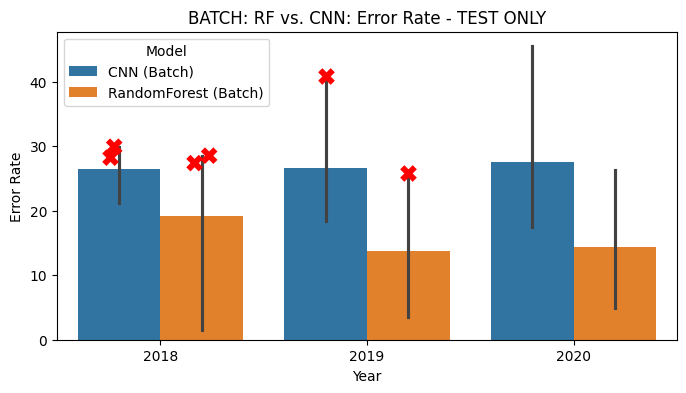

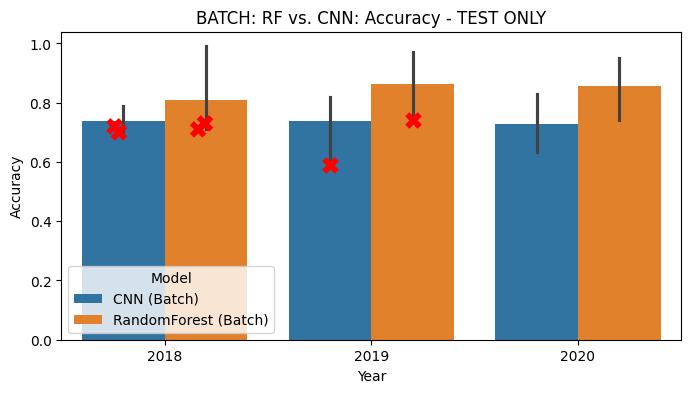

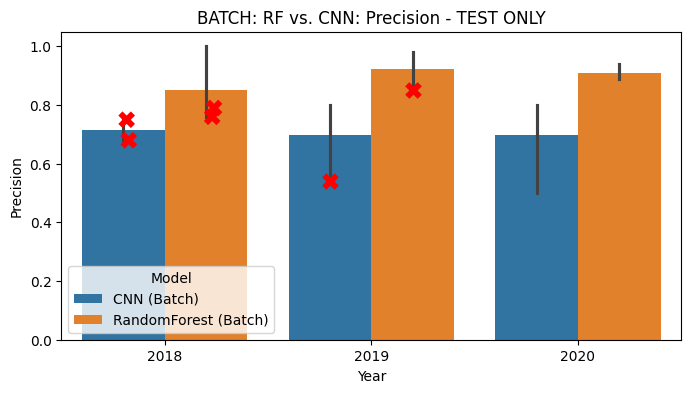

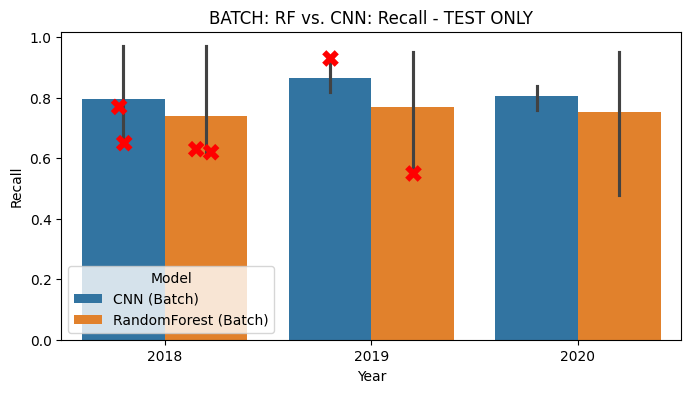

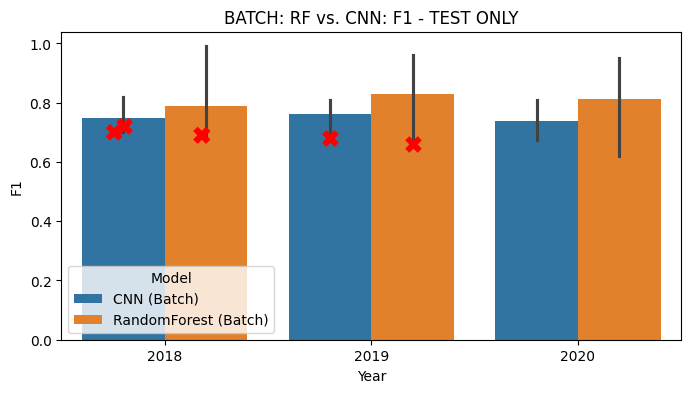

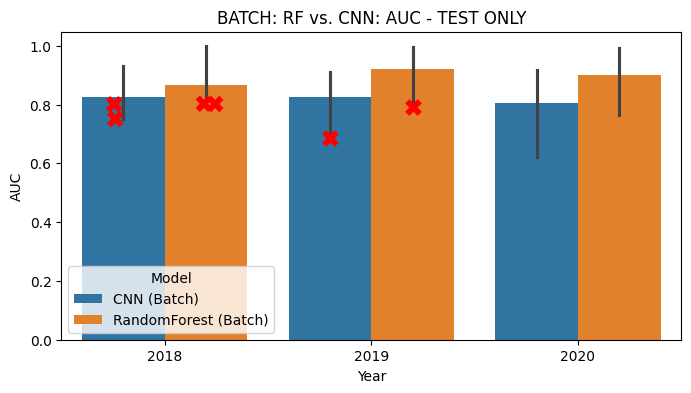


=== CNN (Batch) Testfase: ===
                  Scenario  Year  Accuracy  Error Rate  Precision  Recall  \
0  Scenario 1 (Start 2018)  2018      0.79       21.24       0.71    0.97   
1  Scenario 1 (Start 2018)  2019      0.59       40.84       0.54    0.93   
2  Scenario 1 (Start 2018)  2020      0.55       45.44       0.50    0.84   
3  Scenario 2 (Start 2019)  2018      0.72       28.20       0.75    0.65   
4  Scenario 2 (Start 2019)  2019      0.82       18.38       0.80    0.82   
5  Scenario 2 (Start 2019)  2020      0.80       19.94       0.79    0.76   
6  Scenario 3 (Start 2020)  2018      0.70       29.90       0.68    0.77   
7  Scenario 3 (Start 2020)  2019      0.80       20.40       0.75    0.85   
8  Scenario 3 (Start 2020)  2020      0.83       17.41       0.80    0.82   

     F1  Drifts  
0  0.82       0  
1  0.68       1  
2  0.63       0  
3  0.70       1  
4  0.81       0  
5  0.77       0  
6  0.72       1  
7  0.80       0  
8  0.81       0  

=== RandomForest 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score)

##############################################################################
# 1) ADWIN
##############################################################################
class ADWIN:
    def __init__(self, delta=0.90):
        self.delta = delta
        self.data_window = []
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

    def _calculate_hoeffding_bound(self, n):
        return np.sqrt((1/(2*n)) * np.log(1/self.delta))

    def update(self, value):
        self.data_window.append(value)
        self.width += 1
        self.mean = np.mean(self.data_window)
        self.drift_detected = False
        while len(self.data_window) > 1:
            half = len(self.data_window)//2
            if abs(np.mean(self.data_window[:half]) - np.mean(self.data_window[half:])) > self._calculate_hoeffding_bound(self.width):
                # Drift gedetecteerd, verwijder oudste
                self.data_window.pop(0)
                self.width -= 1
                self.mean = np.mean(self.data_window)
                self.drift_detected = True
            else:
                break
        return self.mean, self.width

    def detected_change(self):
        return self.drift_detected

    def reset(self):
        self.data_window.clear()
        self.mean, self.width = 0.0, 0
        self.drift_detected = False


##############################################################################
# 2) Evaluatiefunctie: Accuracy, Error, Precision, Recall, F1, AUC
##############################################################################
def evaluate_batch(model, X, y):
    """Voorspelt en geeft metrics in dict-vorm (zonder AUC als 'AttributeError')."""
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    err = (1 - acc)*100
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', pos_label=1)
    try:
        # Niet alle modellen hebben predict_proba (o.a. Perceptron), hence try/except
        auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    except AttributeError:
        auc = np.nan
    return dict(Accuracy=acc, Error=err, Precision=prec, Recall=rec, F1=f1, AUC=auc)


##############################################################################
# 3) Data & Scenario's
#    (Vervang X_train_2018, y_train_2018, etc. door je eigen data)
##############################################################################
data_dict = {
    2018: {
        'X_train': X_train_2018, 'y_train': y_train_2018,
        'X_val':   X_val_2018,   'y_val':   y_val_2018,
        'X_test':  X_test_2018,  'y_test':  y_test_2018
    },
    2019: {
        'X_train': X_train_2019, 'y_train': y_train_2019,
        'X_val':   X_val_2019,   'y_val':   y_val_2019,
        'X_test':  X_test_2019,  'y_test':  y_test_2019
    },
    2020: {
        'X_train': X_train_2020, 'y_train': y_train_2020,
        'X_val':   X_val_2020,   'y_val':   y_val_2020,
        'X_test':  X_test_2020,  'y_test':  y_test_2020
    }
}

scenarios = [
    dict(
        scenario_name="Scenario 1 (Start 2018)",
        start_year=2018,
        val_order=[2018, 2019, 2020],
        test_order=[2018, 2019, 2020]
    ),
    dict(
        scenario_name="Scenario 2 (Start 2019)",
        start_year=2019,
        val_order=[2019, 2018, 2020],
        test_order=[2019, 2018, 2020]
    ),
    dict(
        scenario_name="Scenario 3 (Start 2020)",
        start_year=2020,
        val_order=[2020, 2018, 2019],
        test_order=[2020, 2018, 2019]
    )
]


##############################################################################
# 5) Batch models: RandomForest + CNN
#    We vergelijken nu 2 batch-modellen in één run.
##############################################################################
input_dim_ = X_train_2018.shape[1]  # aantal features

batch_model_configs = {
    "CNN (Batch)": CNNBatchModel(
        input_dim=input_dim_,
        num_classes=2,
        epochs=10,
        batch_size=32,
        verbose=1,        # of 0 als je minder output wilt
        learning_rate=1e-3,
        dropout_rate=0.3
    ),
    "RandomForest (Batch)": RandomForestClassifier(random_state=42)
}




# Online-model: bv. SGD
online_model_configs = {
    "SGD (Online)": SGDClassifier(loss="log_loss", warm_start=True, random_state=42)
}


##############################################################################
# 6) Universele scenario-run
##############################################################################
def detect_drift(adwin, error_rate):
    mean_before = adwin.mean
    adwin.update(error_rate/100.0)
    bound = adwin._calculate_hoeffding_bound(adwin.width)
    return "Drift" if abs(mean_before - adwin.mean) > bound else "Stable"

def result_row(scenario, model_name, phase, year, metrics, drift):
    return {
        "Scenario": scenario['scenario_name'],
        "Model": model_name,
        "Phase": phase,
        "Year": year,
        "Accuracy": round(metrics["Accuracy"],2),
        "Error Rate": round(metrics["Error"],2),
        "Precision": round(metrics["Precision"],2),
        "Recall": round(metrics["Recall"],2),
        "F1": round(metrics["F1"],2),
        "AUC": round(metrics["AUC"],3) if not np.isnan(metrics["AUC"]) else np.nan,
        "Drift Status": drift
    }

def run_scenario(scenario, model_dict, mode="batch", adwin_delta=0.90):
    results=[]
    for model_name, model in model_dict.items():
        # Sla online-modellen over als je 'mode=="batch"' en er geen partial_fit is
        if mode=="online" and not hasattr(model, "partial_fit"):
            continue

        start = scenario['start_year']
        # 1) Initieel fitten (batch)
        model.fit(data_dict[start]['X_train'], data_dict[start]['y_train'])

        adwin = ADWIN(adwin_delta)

        # 2) Validatie
        for year in scenario['val_order']:
            if mode=="online" and year != start:
                # partial_fit
                model.partial_fit(data_dict[year]['X_train'], data_dict[year]['y_train'])

            mets = evaluate_batch(model, data_dict[year]['X_val'], data_dict[year]['y_val'])
            drift = "N/A" if year==start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Validation", year, mets, drift))

        # 3) Test
        adwin.reset()
        for year in scenario['test_order']:
            mets = evaluate_batch(model, data_dict[year]['X_test'], data_dict[year]['y_test'])
            drift = "N/A" if year==start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Test", year, mets, drift))

    return results


##############################################################################
# 7) Run batch + online
##############################################################################
all_batch = []
all_online = []

for sc in scenarios:
    # BATCH: test CNN en RandomForest
    all_batch.extend(
        run_scenario(sc, batch_model_configs, mode="batch", adwin_delta=0.90)
    )
    # ONLINE: test enkel SGD
    all_online.extend(
        run_scenario(sc, online_model_configs, mode="online", adwin_delta=0.90)
    )

df_batch = pd.DataFrame(all_batch)
df_batch["Learning"] = "Batch"
df_online = pd.DataFrame(all_online)
df_online["Learning"] = "Online"

df_combined = pd.concat([df_batch, df_online], ignore_index=True)

##############################################################################
# 8) Eindfoutmarge-plot
##############################################################################
endfoutmarge_df = (
    df_combined
    .groupby(["Scenario", "Phase", "Learning", "Model"], as_index=False)["Error Rate"]
    .mean()
    .rename(columns={"Error Rate":"Eindfoutmarge"})
)

print("\n=== df_combined ===\n", df_combined)
print("\n=== Eindfoutmarge ===\n", endfoutmarge_df)


##############################################################################
# 9) Metric-barplot + driftmarkers, etc.
##############################################################################
# Je kunt net als eerder barplots maken, nu met extra hue="Model" om RF vs. CNN te vergelijken.
def plot_metric_barplusdrift(df, metric, title_prefix):
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=df, x="Year", y=metric, hue="Model", dodge=True)
    plt.title(f"{title_prefix}: {metric} - TEST ONLY")

    # Rijen met drift
    drift_df = df[df["Drift Status"]=="Drift"]
    if not drift_df.empty:
        sns.stripplot(
            data=drift_df, x="Year", y=metric, hue="Model",
            marker="X", size=12, palette=["red"]*len(drift_df["Model"].unique()),
            dodge=True, edgecolor="black", ax=ax, legend=False
        )

    ax.legend(title="Model")
    plt.show()

# Filter op Batch + Testfase
df_batch_test = df_combined[
    (df_combined["Phase"]=="Test") & (df_combined["Learning"]=="Batch")
].copy()

for m in ["Error Rate", "Accuracy", "Precision", "Recall", "F1", "AUC"]:
    plot_metric_barplusdrift(df_batch_test, m, "BATCH: RF vs. CNN")

# 1) Maak een DataFrame met ALLE batch + test-resultaten (zowel CNN als RF)
df_batch_test = df_combined[
    (df_combined["Phase"] == "Test") & (df_combined["Learning"] == "Batch")
].copy()

# 2) Verwerk CNN-resultaten in aparte tabel
df_batch_cnn = df_batch_test[df_batch_test["Model"] == "CNN (Batch)"].copy()
df_batch_cnn_summary = (
    df_batch_cnn
    .groupby(["Scenario", "Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        # Voor drift kun je de incidenten tellen:
        # maak evt. eerst een binaire kolom: 1 als "Drift", 0 als "Stable"
        # of tel gewoon hoe vaak "Drift Status" is "Drift"
        # Hieronder voorbeeld dat we “Drift” tellen:
    })
    .round(2)
)

# Om drifts te tellen (optioneel), kun je dit doen:
df_batch_cnn["DriftBinary"] = df_batch_cnn["Drift Status"].eq("Drift").astype(int)
df_driftcount_cnn = (
    df_batch_cnn
    .groupby(["Scenario","Year"], as_index=False)["DriftBinary"].sum()
    .rename(columns={"DriftBinary": "Drifts"})
)
# Merge het aantal drifts in de samenvatting:
df_batch_cnn_summary = pd.merge(df_batch_cnn_summary, df_driftcount_cnn,
                                on=["Scenario","Year"], how="left")

print("\n=== CNN (Batch) Testfase: ===")
print(df_batch_cnn_summary)


# 3) Verwerk RandomForest-resultaten in aparte tabel
df_batch_rf = df_batch_test[df_batch_test["Model"] == "RandomForest (Batch)"].copy()
df_batch_rf_summary = (
    df_batch_rf
    .groupby(["Scenario", "Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
    })
    .round(2)
)

# Optioneel: drifts bijtellen
df_batch_rf["DriftBinary"] = df_batch_rf["Drift Status"].eq("Drift").astype(int)
df_driftcount_rf = (
    df_batch_rf
    .groupby(["Scenario","Year"], as_index=False)["DriftBinary"].sum()
    .rename(columns={"DriftBinary": "Drifts"})
)
df_batch_rf_summary = pd.merge(df_batch_rf_summary, df_driftcount_rf,
                               on=["Scenario","Year"], how="left")

print("\n=== RandomForest (Batch) Testfase: ===")
print(df_batch_rf_summary)


###CNN complex

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

class CNNBatchModel:
    """
    Een meerlaagse 1D Convolutional Neural Network (CNN) voor batch learning,
    specifiek ontworpen voor (N, input_dim)-data, bijvoorbeeld 300D FastText-embeddings.
    Deze versie heeft flink uitgebreide convolutieblokken, meer filters, en meerdere Dense-lagen,
    waardoor het model complexer is en mogelijk meer expressiviteit biedt.

    Voorbeeldgebruik:
        model = CNNBatchModel(
            input_dim=300,
            num_classes=2,
            epochs=150,
            batch_size=64,
            verbose=1,
            learning_rate=1e-4,
            dropout_rate=0.4
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    """

    def __init__(
        self,
        input_dim,
        num_classes=2,
        epochs=150,
        batch_size=64,
        verbose=0,
        learning_rate=1e-4,
        dropout_rate=0.4
    ):
        """
        Parameters
        ----------
        input_dim      : int
            Aantal features (typisch 300 bij FastText).
        num_classes    : int
            Aantal classificatieklassen (2 voor phishing vs. niet-phishing).
        epochs         : int
            Aantal trainingsrondes (default=150).
        batch_size     : int
            Grootte van de minibatches (default=64).
        verbose        : int
            0=geen console-uitvoer, 1=beperkte output, 2=meer details.
        learning_rate  : float
            Leer- (stap)grootte van de optimizer (default=1e-4).
        dropout_rate   : float
            Dropout-fractie (0..1). Hogere waarde => meer regularisatie (default=0.4).
        """
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self._model = None

    def _build_model(self):
        """
        Bouwt een uitgebreide 1D-CNN:
        - Input + Reshape: (input_dim,) -> (input_dim, 1)
        - Convolutieblok 1: Conv(32 filters, kernel=5) + BatchNorm + Dropout
        - Convolutieblok 2: Conv(32 filters, kernel=3) + BatchNorm + Dropout
        - Convolutieblok 3: Conv(64 filters, kernel=3) + BatchNorm + Dropout
        - Convolutieblok 4: Conv(128 filters, kernel=3) + BatchNorm + Dropout
        - Global Max Pooling
        - Dense-blok 1 (128 neuronen) + Dropout
        - Dense-blok 2 (64 neuronen) + Dropout
        - Dense-blok 3 (64 neuronen) + Dropout
        - Output-laag (softmax, num_classes)
        """

        model = models.Sequential()

        # Invoer: (input_dim,) -> Reshape naar (input_dim, 1)
        model.add(layers.Input(shape=(self.input_dim,)))
        model.add(layers.Reshape((self.input_dim, 1)))

        # Convolutieblok 1
        model.add(layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(self.dropout_rate))

        # Convolutieblok 2
        model.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(self.dropout_rate))

        # Convolutieblok 3
        model.add(layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(self.dropout_rate))

        # Convolutieblok 4
        model.add(layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(self.dropout_rate))

        # Pooling
        model.add(layers.GlobalMaxPooling1D())

        # Dense-blok 1
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(self.dropout_rate))

        # Dense-blok 2
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(self.dropout_rate))

        # Dense-blok 3
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(self.dropout_rate))

        # Output-laag
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        # Compile met Adam-optimalisatie
        optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def fit(self, X, y):
        """
        Traint het CNN in batch-modus.

        Parameters
        ----------
        X : ndarray, shape (n_samples, input_dim)
            De features voor elk sample (bijv. 300D embeddings).
        y : ndarray, shape (n_samples,)
            De labels (0..num_classes-1).
        """
        if self._model is None:
            self._model = self._build_model()

        # One-hot-encoding van de labels
        y_categorical = to_categorical(y, num_classes=self.num_classes)

        # Model trainen
        self._model.fit(
            X, y_categorical,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose
        )

    def predict(self, X):
        """
        Geeft de voorspelde klassen (0..num_classes-1) voor de invoer X.
        """
        probs = self._model.predict(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        """
        Geeft de voorspelde kansverdeling per klasse, shape (n_samples, num_classes).
        """
        return self._model.predict(X)


Epoch 1/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5488 - loss: 0.7764
Epoch 2/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6529 - loss: 0.5983
Epoch 3/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7602 - loss: 0.4906
Epoch 4/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8033 - loss: 0.4299
Epoch 5/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8443 - loss: 0.3656
Epoch 6/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8570 - loss: 0.3369
Epoch 7/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8686 - loss: 0.3192
Epoch 8/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8737 - loss: 0.3097
Epoch 9/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8860 - loss: 0.2847
Epoch 10/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8864 - loss: 0.2885
Epoch 11/100
594/594 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8847 - loss: 0.2896
Epoch 12/100
594/594 ━━━━━━━━━━━━━━━━━━

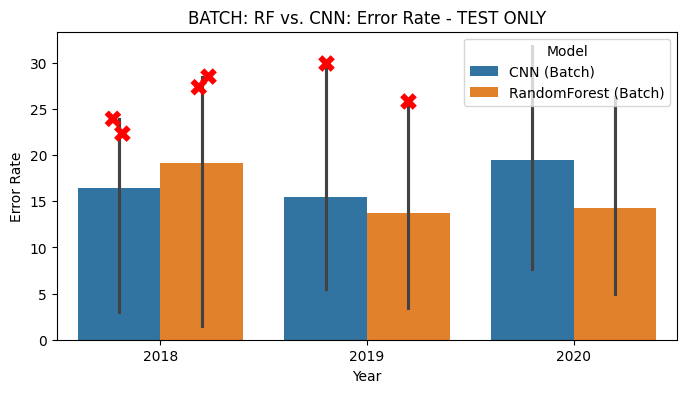

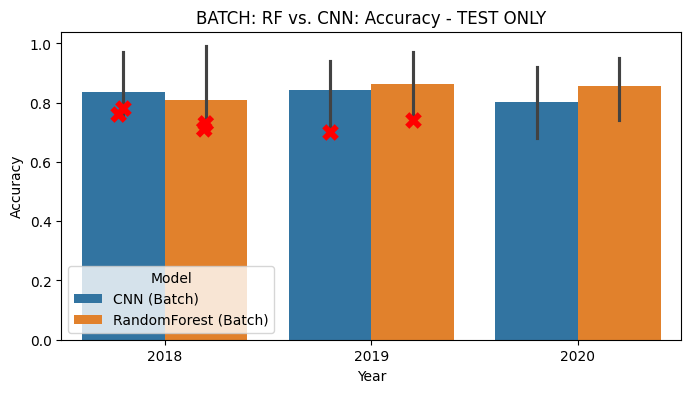

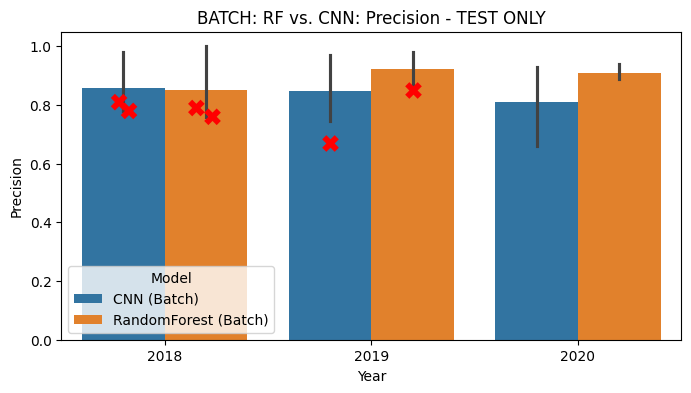

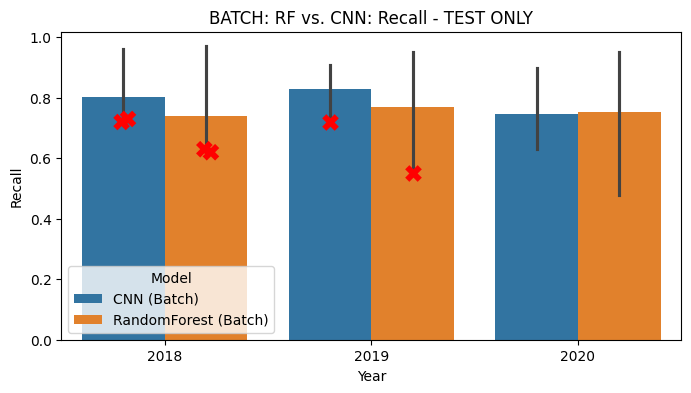

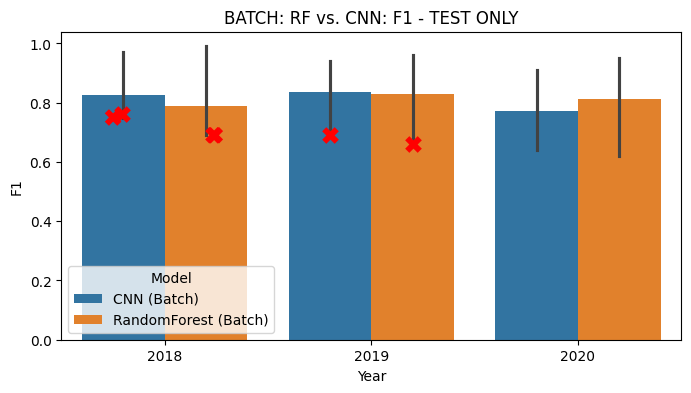

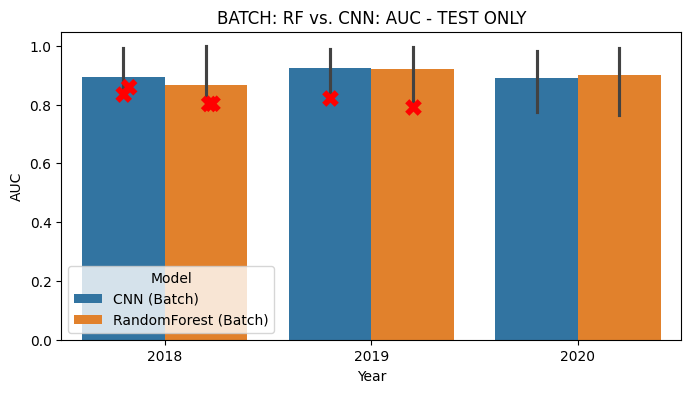


=== CNN (Batch) Testfase: ===
                  Scenario  Year  Accuracy  Error Rate  Precision  Recall  \
0  Scenario 1 (Start 2018)  2018      0.97        2.99       0.98    0.96   
1  Scenario 1 (Start 2018)  2019      0.70       29.93       0.67    0.72   
2  Scenario 1 (Start 2018)  2020      0.68       31.78       0.66    0.63   
3  Scenario 2 (Start 2019)  2018      0.78       22.33       0.81    0.72   
4  Scenario 2 (Start 2019)  2019      0.94        5.53       0.97    0.91   
5  Scenario 2 (Start 2019)  2020      0.81       19.12       0.84    0.71   
6  Scenario 3 (Start 2020)  2018      0.76       23.93       0.78    0.73   
7  Scenario 3 (Start 2020)  2019      0.89       10.80       0.90    0.86   
8  Scenario 3 (Start 2020)  2020      0.92        7.63       0.93    0.90   

     F1  Drifts  
0  0.97       0  
1  0.69       1  
2  0.64       0  
3  0.76       1  
4  0.94       0  
5  0.77       0  
6  0.75       1  
7  0.88       0  
8  0.91       0  

=== RandomForest 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score)

##############################################################################
# 1) ADWIN
##############################################################################
class ADWIN:
    def __init__(self, delta=0.90):
        self.delta = delta
        self.data_window = []
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

    def _calculate_hoeffding_bound(self, n):
        return np.sqrt((1/(2*n)) * np.log(1/self.delta))

    def update(self, value):
        self.data_window.append(value)
        self.width += 1
        self.mean = np.mean(self.data_window)
        self.drift_detected = False
        while len(self.data_window) > 1:
            half = len(self.data_window)//2
            if abs(np.mean(self.data_window[:half]) - np.mean(self.data_window[half:])) > self._calculate_hoeffding_bound(self.width):
                # Drift gedetecteerd, verwijder oudste
                self.data_window.pop(0)
                self.width -= 1
                self.mean = np.mean(self.data_window)
                self.drift_detected = True
            else:
                break
        return self.mean, self.width

    def detected_change(self):
        return self.drift_detected

    def reset(self):
        self.data_window.clear()
        self.mean, self.width = 0.0, 0
        self.drift_detected = False


##############################################################################
# 2) Evaluatiefunctie: Accuracy, Error, Precision, Recall, F1, AUC
##############################################################################
def evaluate_batch(model, X, y):
    """Voorspelt en geeft metrics in dict-vorm (zonder AUC als 'AttributeError')."""
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    err = (1 - acc)*100
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', pos_label=1)
    try:
        # Niet alle modellen hebben predict_proba (o.a. Perceptron), hence try/except
        auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    except AttributeError:
        auc = np.nan
    return dict(Accuracy=acc, Error=err, Precision=prec, Recall=rec, F1=f1, AUC=auc)


##############################################################################
# 3) Data & Scenario's
#    (Vervang X_train_2018, y_train_2018, etc. door je eigen data)
##############################################################################
data_dict = {
    2018: {
        'X_train': X_train_2018, 'y_train': y_train_2018,
        'X_val':   X_val_2018,   'y_val':   y_val_2018,
        'X_test':  X_test_2018,  'y_test':  y_test_2018
    },
    2019: {
        'X_train': X_train_2019, 'y_train': y_train_2019,
        'X_val':   X_val_2019,   'y_val':   y_val_2019,
        'X_test':  X_test_2019,  'y_test':  y_test_2019
    },
    2020: {
        'X_train': X_train_2020, 'y_train': y_train_2020,
        'X_val':   X_val_2020,   'y_val':   y_val_2020,
        'X_test':  X_test_2020,  'y_test':  y_test_2020
    }
}

scenarios = [
    dict(
        scenario_name="Scenario 1 (Start 2018)",
        start_year=2018,
        val_order=[2018, 2019, 2020],
        test_order=[2018, 2019, 2020]
    ),
    dict(
        scenario_name="Scenario 2 (Start 2019)",
        start_year=2019,
        val_order=[2019, 2018, 2020],
        test_order=[2019, 2018, 2020]
    ),
    dict(
        scenario_name="Scenario 3 (Start 2020)",
        start_year=2020,
        val_order=[2020, 2018, 2019],
        test_order=[2020, 2018, 2019]
    )
]


##############################################################################
# 5) Batch models: RandomForest + CNN
#    We vergelijken nu 2 batch-modellen in één run.
##############################################################################
input_dim_ = X_train_2018.shape[1]  # aantal features

batch_model_configs = {
    "CNN (Batch)": CNNBatchModel(
        input_dim=input_dim_,
        num_classes=2,
        epochs=100,
        batch_size=32,
        verbose=1,        # of 0 als je minder output wilt
        learning_rate=1e-3,
        dropout_rate=0.2
    ),
    "RandomForest (Batch)": RandomForestClassifier(random_state=42)
}




# Online-model: bv. SGD
online_model_configs = {
    "SGD (Online)": SGDClassifier(loss="log_loss", warm_start=True, random_state=42)
}


##############################################################################
# 6) Universele scenario-run
##############################################################################
def detect_drift(adwin, error_rate):
    mean_before = adwin.mean
    adwin.update(error_rate/100.0)
    bound = adwin._calculate_hoeffding_bound(adwin.width)
    return "Drift" if abs(mean_before - adwin.mean) > bound else "Stable"

def result_row(scenario, model_name, phase, year, metrics, drift):
    return {
        "Scenario": scenario['scenario_name'],
        "Model": model_name,
        "Phase": phase,
        "Year": year,
        "Accuracy": round(metrics["Accuracy"],2),
        "Error Rate": round(metrics["Error"],2),
        "Precision": round(metrics["Precision"],2),
        "Recall": round(metrics["Recall"],2),
        "F1": round(metrics["F1"],2),
        "AUC": round(metrics["AUC"],3) if not np.isnan(metrics["AUC"]) else np.nan,
        "Drift Status": drift
    }

def run_scenario(scenario, model_dict, mode="batch", adwin_delta=0.90):
    results=[]
    for model_name, model in model_dict.items():
        # Sla online-modellen over als je 'mode=="batch"' en er geen partial_fit is
        if mode=="online" and not hasattr(model, "partial_fit"):
            continue

        start = scenario['start_year']
        # 1) Initieel fitten (batch)
        model.fit(data_dict[start]['X_train'], data_dict[start]['y_train'])

        adwin = ADWIN(adwin_delta)

        # 2) Validatie
        for year in scenario['val_order']:
            if mode=="online" and year != start:
                # partial_fit
                model.partial_fit(data_dict[year]['X_train'], data_dict[year]['y_train'])

            mets = evaluate_batch(model, data_dict[year]['X_val'], data_dict[year]['y_val'])
            drift = "N/A" if year==start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Validation", year, mets, drift))

        # 3) Test
        adwin.reset()
        for year in scenario['test_order']:
            mets = evaluate_batch(model, data_dict[year]['X_test'], data_dict[year]['y_test'])
            drift = "N/A" if year==start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Test", year, mets, drift))

    return results


##############################################################################
# 7) Run batch + online
##############################################################################
all_batch = []
all_online = []

for sc in scenarios:
    # BATCH: test CNN en RandomForest
    all_batch.extend(
        run_scenario(sc, batch_model_configs, mode="batch", adwin_delta=0.90)
    )
    # ONLINE: test enkel SGD
    all_online.extend(
        run_scenario(sc, online_model_configs, mode="online", adwin_delta=0.90)
    )

df_batch = pd.DataFrame(all_batch)
df_batch["Learning"] = "Batch"
df_online = pd.DataFrame(all_online)
df_online["Learning"] = "Online"

df_combined = pd.concat([df_batch, df_online], ignore_index=True)

##############################################################################
# 8) Eindfoutmarge-plot
##############################################################################
endfoutmarge_df = (
    df_combined
    .groupby(["Scenario", "Phase", "Learning", "Model"], as_index=False)["Error Rate"]
    .mean()
    .rename(columns={"Error Rate":"Eindfoutmarge"})
)

print("\n=== df_combined ===\n", df_combined)
print("\n=== Eindfoutmarge ===\n", endfoutmarge_df)


##############################################################################
# 9) Metric-barplot + driftmarkers, etc.
##############################################################################
# Je kunt net als eerder barplots maken, nu met extra hue="Model" om RF vs. CNN te vergelijken.
def plot_metric_barplusdrift(df, metric, title_prefix):
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=df, x="Year", y=metric, hue="Model", dodge=True)
    plt.title(f"{title_prefix}: {metric} - TEST ONLY")

    # Rijen met drift
    drift_df = df[df["Drift Status"]=="Drift"]
    if not drift_df.empty:
        sns.stripplot(
            data=drift_df, x="Year", y=metric, hue="Model",
            marker="X", size=12, palette=["red"]*len(drift_df["Model"].unique()),
            dodge=True, edgecolor="black", ax=ax, legend=False
        )

    ax.legend(title="Model")
    plt.show()

# Filter op Batch + Testfase
df_batch_test = df_combined[
    (df_combined["Phase"]=="Test") & (df_combined["Learning"]=="Batch")
].copy()

for m in ["Error Rate", "Accuracy", "Precision", "Recall", "F1", "AUC"]:
    plot_metric_barplusdrift(df_batch_test, m, "BATCH: RF vs. CNN")

# 1) Maak een DataFrame met ALLE batch + test-resultaten (zowel CNN als RF)
df_batch_test = df_combined[
    (df_combined["Phase"] == "Test") & (df_combined["Learning"] == "Batch")
].copy()

# 2) Verwerk CNN-resultaten in aparte tabel
df_batch_cnn = df_batch_test[df_batch_test["Model"] == "CNN (Batch)"].copy()
df_batch_cnn_summary = (
    df_batch_cnn
    .groupby(["Scenario", "Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        # Voor drift kun je de incidenten tellen:
        # maak evt. eerst een binaire kolom: 1 als "Drift", 0 als "Stable"
        # of tel gewoon hoe vaak "Drift Status" is "Drift"
        # Hieronder voorbeeld dat we “Drift” tellen:
    })
    .round(2)
)

# Om drifts te tellen (optioneel), kun je dit doen:
df_batch_cnn["DriftBinary"] = df_batch_cnn["Drift Status"].eq("Drift").astype(int)
df_driftcount_cnn = (
    df_batch_cnn
    .groupby(["Scenario","Year"], as_index=False)["DriftBinary"].sum()
    .rename(columns={"DriftBinary": "Drifts"})
)
# Merge het aantal drifts in de samenvatting:
df_batch_cnn_summary = pd.merge(df_batch_cnn_summary, df_driftcount_cnn,
                                on=["Scenario","Year"], how="left")

print("\n=== CNN (Batch) Testfase: ===")
print(df_batch_cnn_summary)


# 3) Verwerk RandomForest-resultaten in aparte tabel
df_batch_rf = df_batch_test[df_batch_test["Model"] == "RandomForest (Batch)"].copy()
df_batch_rf_summary = (
    df_batch_rf
    .groupby(["Scenario", "Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
    })
    .round(2)
)

# Optioneel: drifts bijtellen
df_batch_rf["DriftBinary"] = df_batch_rf["Drift Status"].eq("Drift").astype(int)
df_driftcount_rf = (
    df_batch_rf
    .groupby(["Scenario","Year"], as_index=False)["DriftBinary"].sum()
    .rename(columns={"DriftBinary": "Drifts"})
)
df_batch_rf_summary = pd.merge(df_batch_rf_summary, df_driftcount_rf,
                               on=["Scenario","Year"], how="left")

print("\n=== RandomForest (Batch) Testfase: ===")
print(df_batch_rf_summary)


#Online models


== df_online ==
                     Scenario                        Model       Phase  Year  \
0    Scenario 1 (Start 2018)                 SGD (Online)  Validation  2018   
1    Scenario 1 (Start 2018)                 SGD (Online)  Validation  2019   
2    Scenario 1 (Start 2018)                 SGD (Online)  Validation  2020   
3    Scenario 1 (Start 2018)                 SGD (Online)        Test  2018   
4    Scenario 1 (Start 2018)                 SGD (Online)        Test  2019   
5    Scenario 1 (Start 2018)                 SGD (Online)        Test  2020   
6    Scenario 1 (Start 2018)          Perceptron (Online)  Validation  2018   
7    Scenario 1 (Start 2018)          Perceptron (Online)  Validation  2019   
8    Scenario 1 (Start 2018)          Perceptron (Online)  Validation  2020   
9    Scenario 1 (Start 2018)          Perceptron (Online)        Test  2018   
10   Scenario 1 (Start 2018)          Perceptron (Online)        Test  2019   
11   Scenario 1 (Start 2018)      

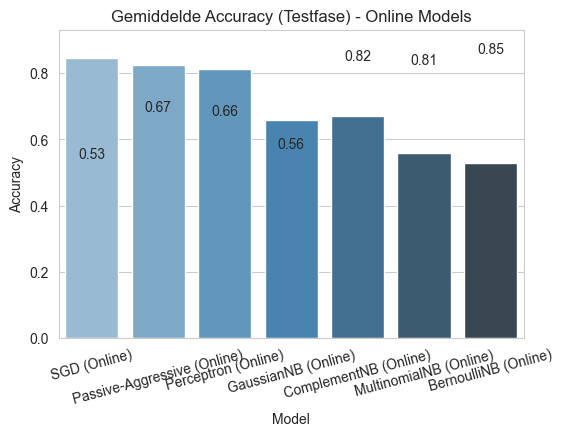

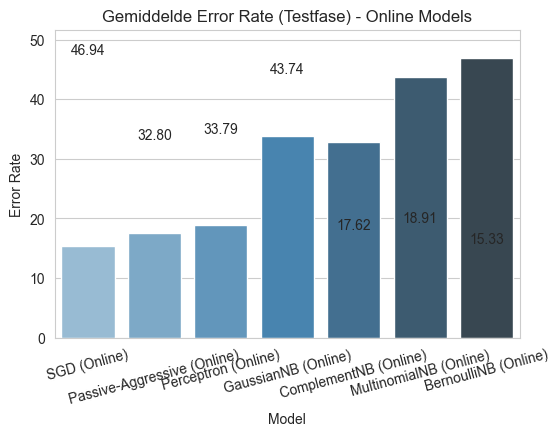

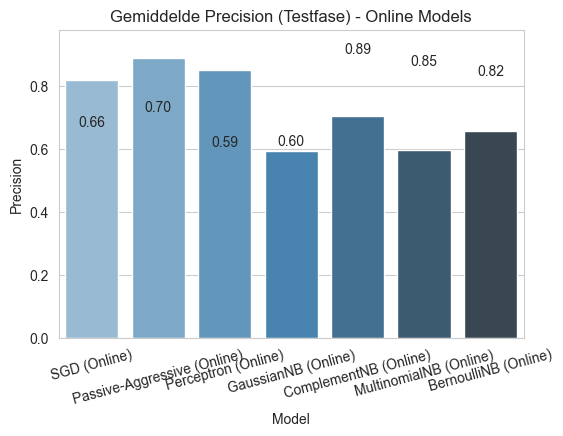

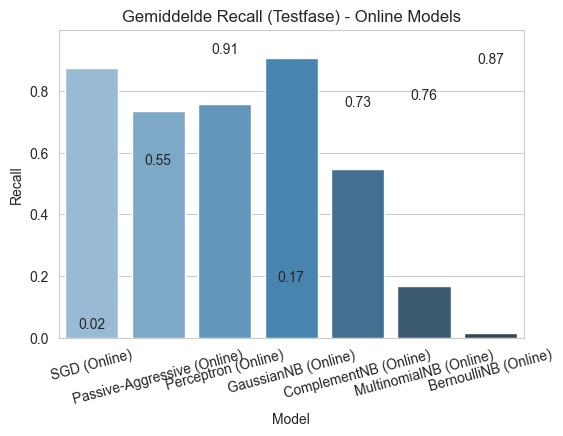

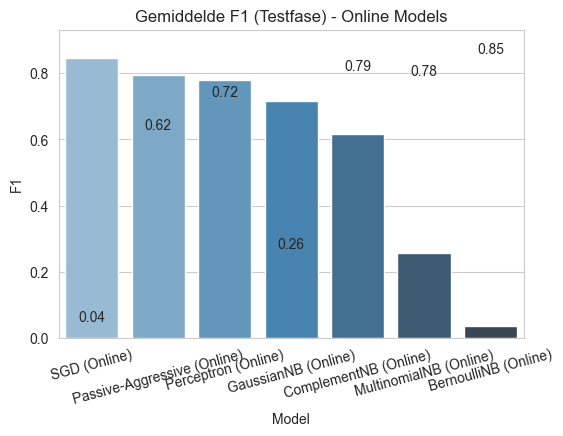


== Aantal gedetecteerde conceptdrifts per model (Testfase) ==
                          Model  Drift Count
0         BernoulliNB (Online)            3
1        ComplementNB (Online)            3
2          GaussianNB (Online)            3
3       MultinomialNB (Online)            3
4  Passive-Aggressive (Online)            1
5          Perceptron (Online)            1
6                 SGD (Online)            1


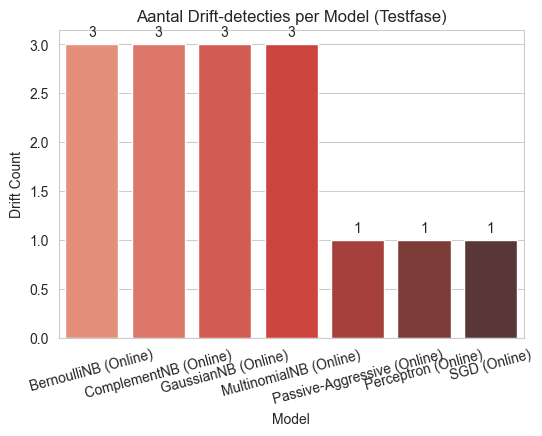

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import (SGDClassifier, Perceptron,
                                  PassiveAggressiveClassifier)
from sklearn.naive_bayes import (BernoulliNB, MultinomialNB,
                                 ComplementNB, GaussianNB)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)


##############################################################################
# 1) ADWIN
##############################################################################
class ADWIN:
    def __init__(self, delta=0.90):
        self.delta = delta
        self.data_window = []
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

    def _calculate_hoeffding_bound(self, n):
        return np.sqrt((1/(2*n)) * np.log(1/self.delta))

    def update(self, value):
        self.data_window.append(value)
        self.width += 1
        self.mean = np.mean(self.data_window)
        self.drift_detected = False

        while len(self.data_window) > 1:
            half = len(self.data_window)//2
            mean0 = np.mean(self.data_window[:half])
            mean1 = np.mean(self.data_window[half:])
            if abs(mean0 - mean1) > self._calculate_hoeffding_bound(self.width):
                self.data_window.pop(0)
                self.width -= 1
                self.mean = np.mean(self.data_window)
                self.drift_detected = True
            else:
                break

        return self.mean, self.width

    def detected_change(self):
        return self.drift_detected

    def reset(self):
        self.data_window.clear()
        self.mean, self.width = 0.0, 0
        self.drift_detected = False


##############################################################################
# 2) Evaluatie: Accuracy, Error, Precision, Recall, F1 (zonder AUC)
##############################################################################
def evaluate_batch(model, X, y):
    """Voorspelt en geeft dictionary terug met metrics (zonder AUC)."""
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    err = (1 - acc)*100
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', pos_label=1)
    return dict(Accuracy=acc, Error=err, Precision=prec, Recall=rec, F1=f1)


##############################################################################
# 3) Data & Scenario's - pas aan naar eigen data_dict en scenario-lijst
##############################################################################
# data_dict = {...}
# scenarios = [...]
# Zorg dat data_dict[year]['X_train'], data_dict[year]['y_train'] etc. bestaan.

##############################################################################
# 4) Online Learning-modellen (SGD, Perceptron, PassiveAggressive, NB)
##############################################################################
online_model_configs = {
    "SGD (Online)": SGDClassifier(warm_start=True, random_state=42),
    "Perceptron (Online)": Perceptron(warm_start=True, random_state=42),
    "Passive-Aggressive (Online)": PassiveAggressiveClassifier(warm_start=False, random_state=42),
    "BernoulliNB (Online)": BernoulliNB(),
    "MultinomialNB (Online)": MultinomialNB(),
    "ComplementNB (Online)": ComplementNB(),
    "GaussianNB (Online)": GaussianNB()
}

##############################################################################
# 5) Helpers: detect_drift, result_row
##############################################################################
def detect_drift(adwin, error_rate):
    before = adwin.mean
    adwin.update(error_rate/100.0)
    return "Drift" if abs(before - adwin.mean) > adwin._calculate_hoeffding_bound(adwin.width) else "Stable"

def result_row(scenario, model_name, phase, year, metrics, drift):
    """Maakt 1 dict-row met resultaten voor df_online."""
    return {
        "Scenario": scenario['scenario_name'],
        "Model": model_name,
        "Phase": phase,
        "Year": year,
        "Accuracy": round(metrics["Accuracy"],2),
        "Error Rate": round(metrics["Error"],2),
        "Precision": round(metrics["Precision"],2),
        "Recall": round(metrics["Recall"],2),
        "F1": round(metrics["F1"],2),
        "Drift Status": drift
    }


##############################################################################
# 6) Scenario-run in Online mode
##############################################################################
def run_scenario(scenario, model_dict, adwin_delta=0.90):
    results=[]
    for model_name, model in model_dict.items():
        # 1) Initieel fit op het startjaar
        start = scenario['start_year']
        X_start = data_dict[start]['X_train']
        y_start = data_dict[start]['y_train']
        model.fit(X_start, y_start)

        adwin = ADWIN(adwin_delta)

        # 2) Validatie + bijtrainen
        for year in scenario['val_order']:
            if year != start:
                # partial_fit
                model.partial_fit(data_dict[year]['X_train'], data_dict[year]['y_train'])
            mets = evaluate_batch(model, data_dict[year]['X_val'], data_dict[year]['y_val'])
            drift = "N/A" if year==start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Validation", year, mets, drift))

        # 3) Test
        adwin.reset()
        for year in scenario['test_order']:
            mets = evaluate_batch(model, data_dict[year]['X_test'], data_dict[year]['y_test'])
            drift = "N/A" if year==start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Test", year, mets, drift))

    return results


##############################################################################
# 7) Run scenario's (Online only)
##############################################################################
all_results_online = []
for sc in scenarios:
    scenario_res = run_scenario(sc, online_model_configs, adwin_delta=0.90)
    all_results_online.extend(scenario_res)

df_online = pd.DataFrame(all_results_online)
df_online["Learning"] = "Online"

print("\n== df_online ==\n", df_online)

##############################################################################
# 8) Gemiddelde scores (Testfase)
##############################################################################
df_online_test = df_online[df_online["Phase"]=="Test"].copy()

mean_scores = (
    df_online_test
    .groupby("Model", as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean"
    })
    .round(3)
    .sort_values(by="F1", ascending=False)  # Sorteer bv. op F1
)

print("\n== Gemiddelde scores (Testfase) per Online Model ==\n", mean_scores)


##############################################################################
# 9) Barplots voor alle metrics
##############################################################################
metrics_list = ["Accuracy", "Error Rate", "Precision", "Recall", "F1"]

for metric in metrics_list:
    plt.figure(figsize=(6,4))
    ax = sns.barplot(data=mean_scores, x="Model", y=metric, palette="Blues_d")
    plt.title(f"Gemiddelde {metric} (Testfase) - Online Models")
    # Tekstlabels boven de balken
    for i, row in mean_scores.iterrows():
        val = row[metric]
        ax.text(i, val + 0.005, f"{val:.2f}", ha='center', va='bottom')
    # Limiet instellen zodat tekst niet eraf valt
    plt.ylim(0, max(mean_scores[metric])*1.1)
    plt.xticks(rotation=15)
    plt.show()


##############################################################################
# 10) Aantal gedetecteerde "Drift" per model
##############################################################################
# We tellen hoe vaak "Drift Status" == "Drift" is op de testfase
df_online_test["DriftBinary"] = (df_online_test["Drift Status"] == "Drift").astype(int)

drift_count = (
    df_online_test
    .groupby("Model")["DriftBinary"]
    .sum()  # Som van 1'jes = aantal drift-gevallen
    .reset_index(name="Drift Count")
)

print("\n== Aantal gedetecteerde conceptdrifts per model (Testfase) ==\n", drift_count)

# Eventueel ook hier een barplot:
plt.figure(figsize=(6,4))
ax = sns.barplot(data=drift_count, x="Model", y="Drift Count", palette="Reds_d")
plt.title("Aantal Drift-detecties per Model (Testfase)")
for i, row in drift_count.iterrows():
    ax.text(i, row["Drift Count"] + 0.05, f"{row['Drift Count']}", ha='center', va='bottom')
plt.xticks(rotation=15)
plt.show()


##SGD

###Parameter GridSearch

In [ ]:
import itertools
from sklearn.model_selection import ParameterGrid
from copy import deepcopy
from tqdm import tqdm
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Zorg ervoor dat de ADWIN klasse, evaluate_batch, log_results, scenarios, data_dict en andere benodigde componenten
# gedefinieerd zijn in je huidige code.
# Bijvoorbeeld:
# from your_module import ADWIN, evaluate_batch, log_results, scenarios, data_dict

# ======================================
# Aparte Codeblok: Hyperparameter Tuning voor Online SGDClassifier met tqdm en Threading Backend
# ======================================
def evaluate_parameter_set_all_scenarios(params, scenarios, data_dict, adwin_delta=0.90):
    """
    Evalueert een parameter set voor alle scenario's gecombineerd en retourneert gemiddelde prestaties.

    Parameters:
    - params: Dictionary met hyperparameters.
    - scenarios: Lijst van scenario's.
    - data_dict: Dictionary met data per jaar.
    - adwin_delta: Delta parameter voor ADWIN drift detectie.

    Returns:
    - Dictionary met parameters, prestaties per scenario en driftstatistieken.
    """
    from sklearn.linear_model import SGDClassifier
    import numpy as np
    from copy import deepcopy

    model = SGDClassifier(
        loss=params.get('loss', 'log_loss'),
        penalty=params.get('penalty', 'l2'),
        alpha=params.get('alpha', 0.0001),
        learning_rate=params.get('learning_rate', 'optimal'),
        eta0=params.get('eta0', 0.0),
        random_state=42
    )

    scenario_results = {}
    all_accuracies, all_error_rates, all_drifts = [], [], []

    for scenario in scenarios:
        model_copy = deepcopy(model)
        start_year = scenario['start_year']
        X_train = data_dict[start_year]['X_train']
        y_train = data_dict[start_year]['y_train']
        model_copy.fit(X_train, y_train)

        adwin = ADWIN(delta=adwin_delta)
        classes = np.unique(y_train)
        scenario_acc, scenario_err, drift_detected = [], [], False

        for year in scenario['val_order']:
            if year != start_year:
                X_tr = data_dict[year]['X_train']
                y_tr = data_dict[year]['y_train']
                model_copy.partial_fit(X_tr, y_tr, classes=classes)

            X_val = data_dict[year]['X_val']
            y_val = data_dict[year]['y_val']
            acc, err = evaluate_batch(model_copy, X_val, y_val)
            adwin.update(err / 100.0)

            # Controleer op drift
            if adwin.detected_change():
                drift_detected = True

            scenario_acc.append(acc)
            scenario_err.append(err)

        avg_acc = np.mean(scenario_acc) * 100
        avg_err = np.mean(scenario_err)
        all_accuracies.append(avg_acc)
        all_error_rates.append(avg_err)
        all_drifts.append(drift_detected)

        scenario_results[scenario['scenario_name']] = {
            'Average Accuracy': avg_acc,
            'Average Error Rate': avg_err,
            'Drift Detected': drift_detected
        }

    overall_avg_acc = np.mean(all_accuracies)
    overall_avg_err = np.mean(all_error_rates)
    stable_model = not any(all_drifts)

    return {
        "Parameters": params,
        "Scenario Results": scenario_results,
        "Overall Average Accuracy": overall_avg_acc,
        "Overall Average Error Rate": overall_avg_err,
        "Stable Model": stable_model
    }

def tune_online_sgd_classifier_combined(scenarios, data_dict, parameter_grid_valid, adwin_delta=0.90, n_jobs=-1):
    """
    Voert hyperparameter tuning uit voor de online SGDClassifier over alle scenario's gecombineerd.
    """
    results = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(evaluate_parameter_set_all_scenarios)(params, scenarios, data_dict, adwin_delta)
        for params in tqdm(parameter_grid_valid, desc="Evaluating Parameter Sets for All Scenarios")
    )

    tuning_df = pd.DataFrame(results)

    # Beste parameters bepalen (gebaseerd op gemiddelde accuracy en stabiliteit)
    best_params = tuning_df[
        (tuning_df['Stable Model'] == True)
    ].sort_values(by="Overall Average Accuracy", ascending=False).iloc[0]["Parameters"]

    return best_params, tuning_df

    # Combineer alle tuning resultaten
    tuning_results_df = pd.concat(all_tuning_results, ignore_index=True)

    return best_params_per_scenario, tuning_results_df


# ======================================
# 11) Definieer het Uitgebreide Parameter Grid Zonder 'adaptive', 'max_iter' en 'tol'
# ======================================

# Nieuwe hyperparameters zonder 'max_iter' en 'tol'
loss_options = ['log_loss', 'modified_huber', 'perceptron']
penalty_options = ['l2', 'l1', 'elasticnet']
alpha_options = [0.00001, 0.0001, 0.001]
learning_rate_options = ['optimal', 'constant']
eta0_options_constant_invscaling = [0.001, 0.01, 0.1, 1.0]
eta0_options_optimal = [0.0]
warm_start_options = [True, False]

# Creëer alleen geldige parameter combinaties waarbij eta0 > 0.0 wanneer learning_rate 'constant' of 'invscaling' is
parameter_grid_valid = []

for loss in loss_options:
    for penalty in penalty_options:
        for alpha in alpha_options:
            for lr in learning_rate_options:
                for warm_start in warm_start_options:
                    if lr in ['constant']:
                        for eta0 in eta0_options_constant_invscaling:
                            parameter_grid_valid.append({
                                'loss': loss,
                                'penalty': penalty,
                                'alpha': alpha,
                                'learning_rate': lr,
                                'eta0': eta0,
                                'warm_start': warm_start
                            })
                    else:  # 'optimal'
                        eta0 = 0.0
                        parameter_grid_valid.append({
                            'loss': loss,
                            'penalty': penalty,
                            'alpha': alpha,
                            'learning_rate': lr,
                            'eta0': eta0,
                            'warm_start': warm_start
                        })

best_parameters_combined, combined_tuning_results_df = tune_online_sgd_classifier_combined(
    scenarios=scenarios,
    data_dict=data_dict,
    parameter_grid_valid=parameter_grid_valid,
    adwin_delta=0.90,
    n_jobs=-1
)

# Log de tuning resultaten
print("\n=== Gecombineerde Hyperparameter Tuning Resultaten ===")
print(combined_tuning_results_df)

# Sla gecombineerde tuning resultaten op als CSV
combined_tuning_results_df.to_csv("combined_tuning_results_online_sgd.csv", index=False)

# Toon de beste parameters
print("\n=== Beste Parameters voor Alle Scenario's ===")
print(best_parameters_combined)

# Controleer stabiliteit van het model
stable_models = combined_tuning_results_df["Stable Model"].value_counts()
print("\n=== Stabiliteit Analyse ===")
print(stable_models)

# Optioneel: Sla de tuning resultaten op als CSV voor latere analyse
tuning_results_df.to_csv("tuning_results_online_sgd_per_scenario.csv", index=False)

# ======================================
# 13) Gebruik de Beste Parameters om Getunede Online Modellen per Scenario te Configureren
# ======================================

online_model_configs_tuned_per_scenario = {}

for scenario in scenarios:
    scenario_name = scenario['scenario_name']
    best_params = best_parameters_per_scenario[scenario_name]

    # Configureer het getunede model voor het scenario
    tuned_model = SGDClassifier(
        loss=best_params.get('loss', 'log_loss'),
        penalty=best_params.get('penalty', 'l2'),
        alpha=best_params.get('alpha', 0.0001),
        learning_rate=best_params.get('learning_rate', 'optimal'),
        eta0=best_params.get('eta0', 0.0),
        random_state=42
    )

    # Voeg het getunede model toe aan de configuratie dictionary met scenario naam
    online_model_configs_tuned_per_scenario[f"SGD (Online, Tuned) - {scenario_name}"] = tuned_model

print("\n=== Getunede Online Model Configuraties per Scenario ===")
for key in online_model_configs_tuned_per_scenario:
    print(f"{key}: {online_model_configs_tuned_per_scenario[key]}")




Evaluating Parameter Sets for All Scenarios:   0%|                                             | 0/270 [00:00<?, ?it/s]

Evaluating Parameter Sets for All Scenarios:   6%|██▏                                 | 16/270 [00:02<00:47,  5.35it/s]

Evaluating Parameter Sets for All Scenarios:   9%|███▏                                | 24/270 [00:08<01:39,  2.47it/s]

Evaluating Parameter Sets for All Scenarios:  12%|████▎                               | 32/270 [00:13<01:52,  2.12it/s]

Evaluating Parameter Sets for All Scenarios:  15%|█████▎                              | 40/270 [00:18<02:03,  1.86it/s]

Evaluating Parameter Sets for All Scenarios:  18%|██████▍                             | 48/270 [00:26<02:32,  1.46it/s]

Evaluating Parameter Sets for All Scenarios:  21%|███████▍                            | 56/270 [00:46<04:28,  1.26s/it]

Evaluating Parameter Sets for All Scenarios:  24%|████████▌                           | 64/270 [01:28<08:42,  2.54s/it]

Evaluating Parameter Sets for 


=== Gecombineerde Hyperparameter Tuning Resultaten ===
                                                                                                                                Parameters  \
0                       {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 1e-05, 'learning_rate': 'optimal', 'eta0': 0.0, 'warm_start': True}   
1                      {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 1e-05, 'learning_rate': 'optimal', 'eta0': 0.0, 'warm_start': False}   
2                    {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 1e-05, 'learning_rate': 'constant', 'eta0': 0.001, 'warm_start': True}   
3                     {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 1e-05, 'learning_rate': 'constant', 'eta0': 0.01, 'warm_start': True}   
4                      {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 1e-05, 'learning_rate': 'constant', 'eta0': 0.1, 'warm_start': True}   
5                      {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 1e-05, 'learning_rate'


###SGD(batch) niet gefinetuned vs SGD(online) gefinetuned

<Figure size 1000x400 with 0 Axes>

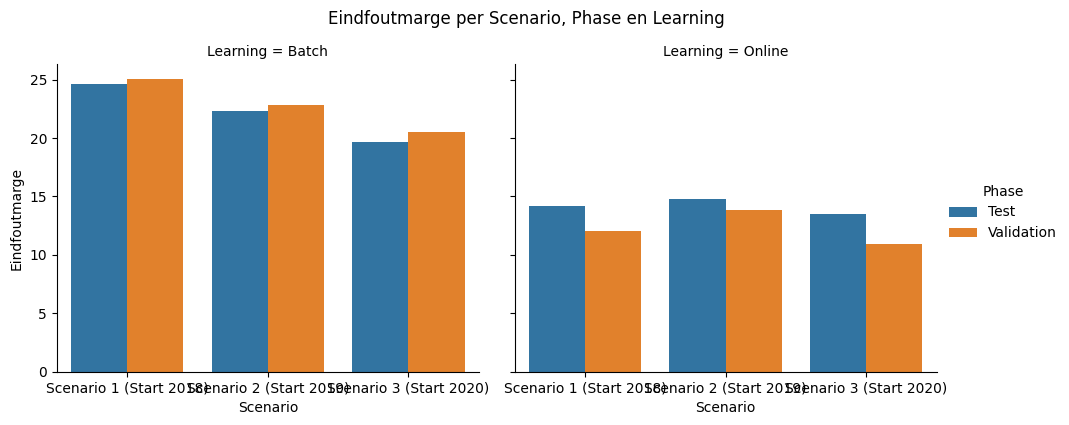

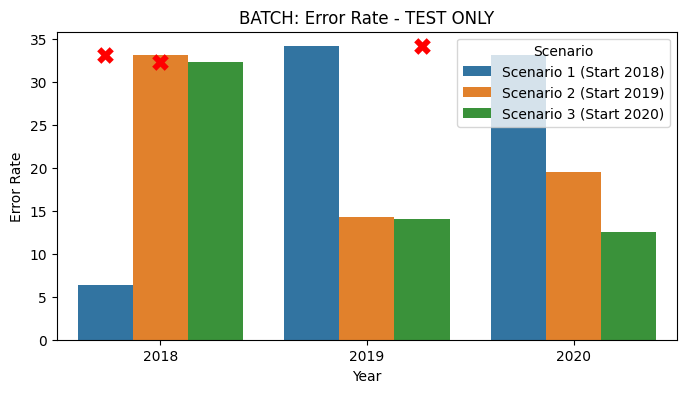

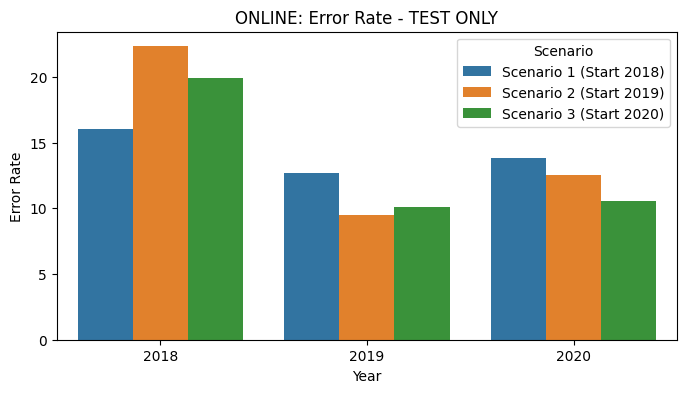

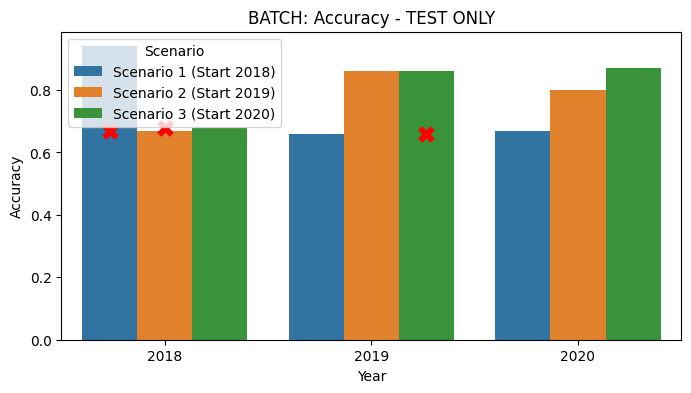

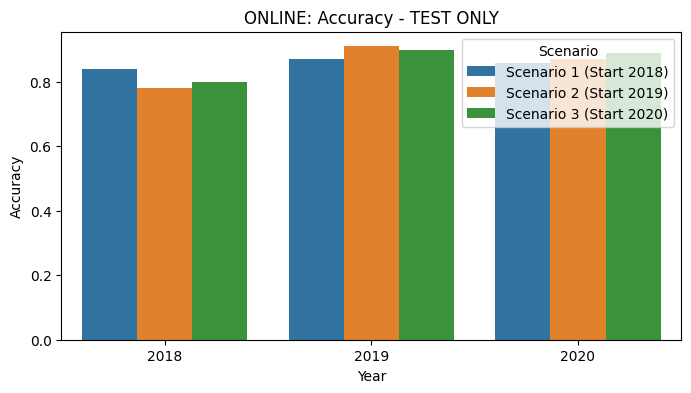

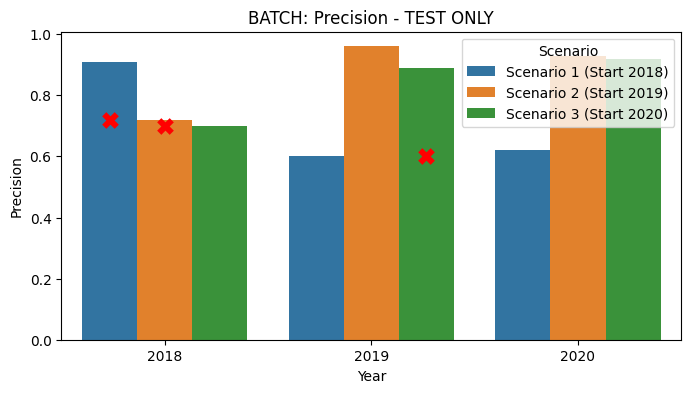

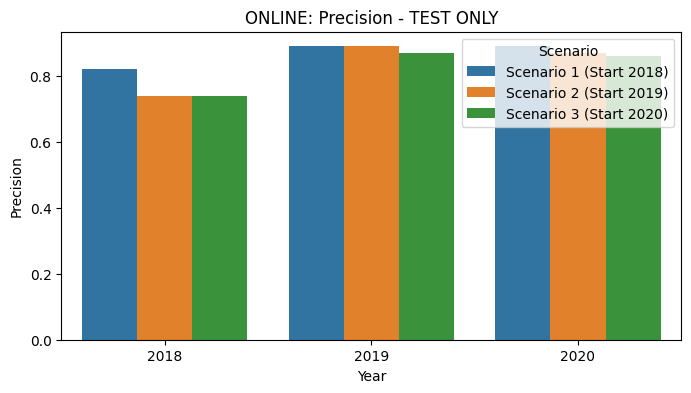

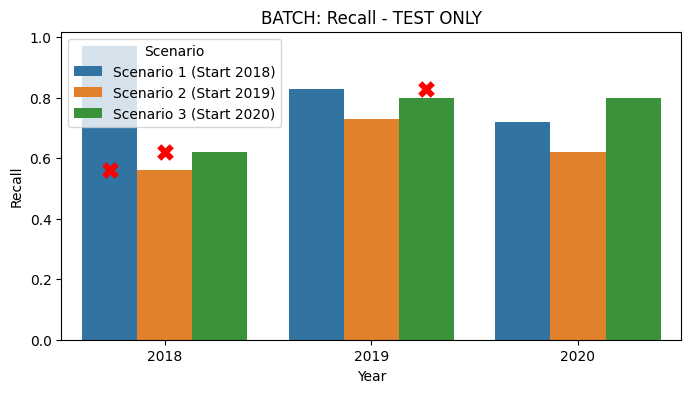

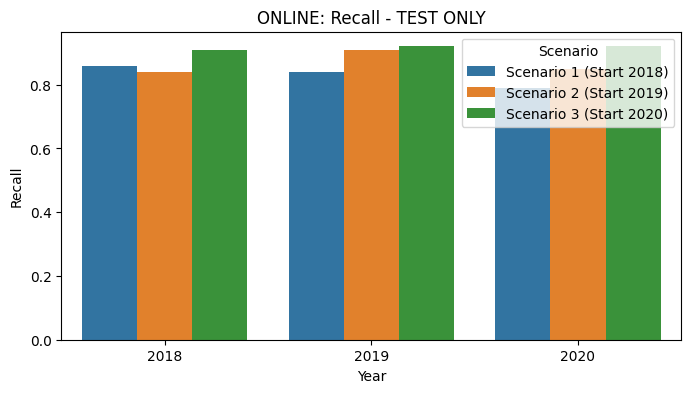

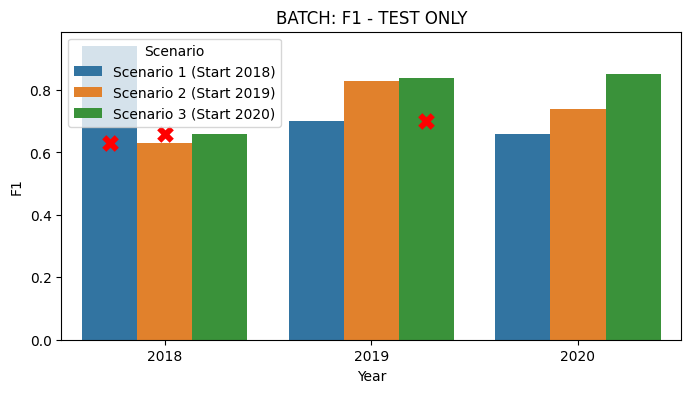

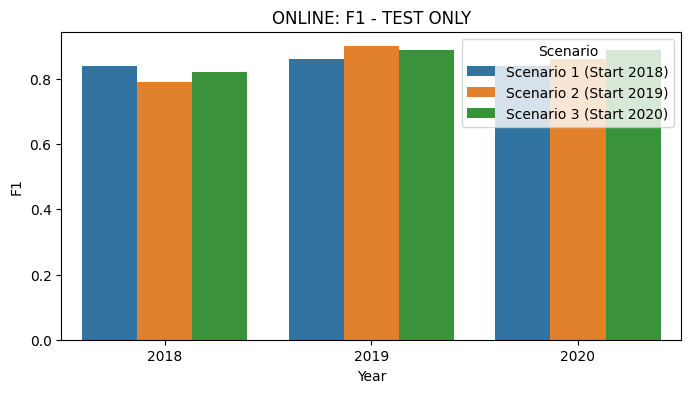

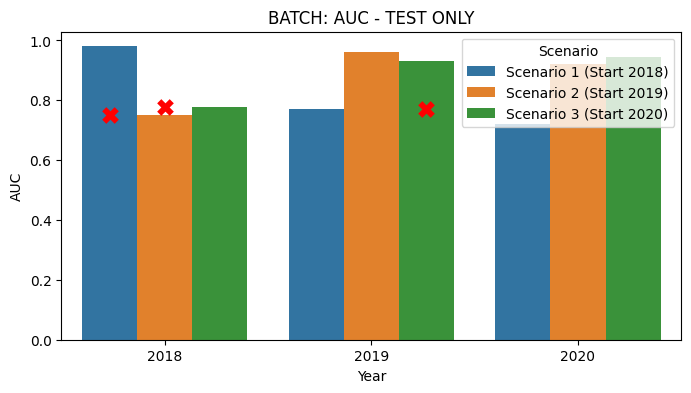

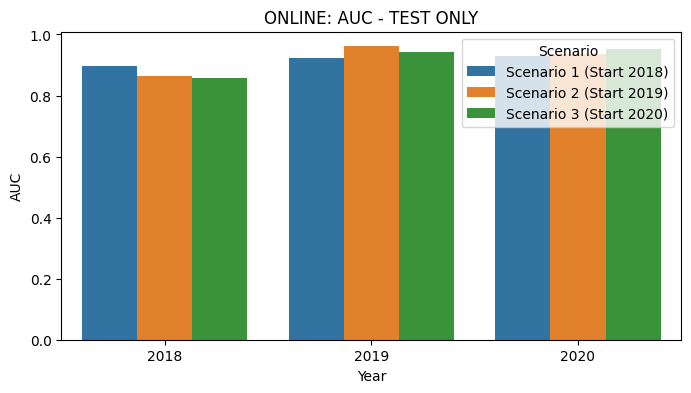


=== df_combined ===
                    Scenario         Model       Phase  Year  Accuracy  \
0   Scenario 1 (Start 2018)   SGD (Batch)  Validation  2018      0.93   
1   Scenario 1 (Start 2018)   SGD (Batch)  Validation  2019      0.65   
2   Scenario 1 (Start 2018)   SGD (Batch)  Validation  2020      0.67   
3   Scenario 1 (Start 2018)   SGD (Batch)        Test  2018      0.94   
4   Scenario 1 (Start 2018)   SGD (Batch)        Test  2019      0.66   
5   Scenario 1 (Start 2018)   SGD (Batch)        Test  2020      0.67   
6   Scenario 2 (Start 2019)   SGD (Batch)  Validation  2019      0.86   
7   Scenario 2 (Start 2019)   SGD (Batch)  Validation  2018      0.66   
8   Scenario 2 (Start 2019)   SGD (Batch)  Validation  2020      0.80   
9   Scenario 2 (Start 2019)   SGD (Batch)        Test  2019      0.86   
10  Scenario 2 (Start 2019)   SGD (Batch)        Test  2018      0.67   
11  Scenario 2 (Start 2019)   SGD (Batch)        Test  2020      0.80   
12  Scenario 3 (Start 2020)  

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score)

##############################################################################
# 1) ADWIN
##############################################################################
class ADWIN:
    def __init__(self, delta=0.90):
        self.delta = delta
        self.data_window = []
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

    def _calculate_hoeffding_bound(self, n):
        return np.sqrt((1/(2*n)) * np.log(1/self.delta))

    def update(self, value):
        self.data_window.append(value)
        self.width += 1
        self.mean = np.mean(self.data_window)
        self.drift_detected = False
        while len(self.data_window) > 1:
            half = len(self.data_window)//2
            if abs(np.mean(self.data_window[:half]) - np.mean(self.data_window[half:])) > self._calculate_hoeffding_bound(self.width):
                self.data_window.pop(0)
                self.width -= 1
                self.mean = np.mean(self.data_window)
                self.drift_detected = True
            else:
                break
        return self.mean, self.width

    def detected_change(self):
        return self.drift_detected

    def reset(self):
        self.data_window.clear()
        self.mean, self.width = 0.0, 0
        self.drift_detected = False

##############################################################################
# 2) Evaluatie: Accuracy, Error, Precision, Recall, F1, AUC
##############################################################################
def evaluate_batch(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    err = (1 - acc)*100
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', pos_label=1)
    try:
        auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    except AttributeError:
        auc = np.nan
    return dict(Accuracy=acc, Error=err, Precision=prec, Recall=rec, F1=f1, AUC=auc)

##############################################################################
# 3) Data & Scenario's (voorbeelden, pas aan naar eigen data)
##############################################################################
data_dict = {
    2018: {'X_train': X_train_2018, 'y_train': y_train_2018,
           'X_val': X_val_2018,     'y_val': y_val_2018,
           'X_test': X_test_2018,  'y_test': y_test_2018},
    2019: {'X_train': X_train_2019, 'y_train': y_train_2019,
           'X_val': X_val_2019,     'y_val': y_val_2019,
           'X_test': X_test_2019,  'y_test': y_test_2019},
    2020: {'X_train': X_train_2020, 'y_train': y_train_2020,
           'X_val': X_val_2020,     'y_val': y_val_2020,
           'X_test': X_test_2020,  'y_test': y_test_2020}
}
scenarios = [
    dict(scenario_name="Scenario 1 (Start 2018)", start_year=2018, val_order=[2018, 2019, 2020], test_order=[2018, 2019, 2020]),
    dict(scenario_name="Scenario 2 (Start 2019)", start_year=2019, val_order=[2019, 2018, 2020], test_order=[2019, 2018, 2020]),
    dict(scenario_name="Scenario 3 (Start 2020)", start_year=2020, val_order=[2020, 2018, 2019], test_order=[2020, 2018, 2019])
]

##############################################################################
# 4) Models
##############################################################################
batch_model_configs = {"SGD (Batch)": SGDClassifier(loss="log_loss", random_state=42)}
#online_model_configs= {"SGD (Online)":SGDClassifier(loss="log_loss", warm_start=True, random_state=42)}
online_model_configs = {"SGD (Online)": SGDClassifier(loss= 'log_loss', penalty= 'l1', alpha= 0.000001, learning_rate= 'constant', eta0= 1.0, warm_start=False, random_state=42)}
##############################################################################
# 5) Universele scenario-run
##############################################################################
def detect_drift(adwin, error_rate):
    before = adwin.mean
    adwin.update(error_rate/100.0)
    return "Drift" if abs(before - adwin.mean) > adwin._calculate_hoeffding_bound(adwin.width) else "Stable"

def result_row(scenario, model_name, phase, year, metrics, drift):
    return {
        "Scenario": scenario['scenario_name'],
        "Model": model_name,
        "Phase": phase,
        "Year": year,
        "Accuracy": round(metrics["Accuracy"],2),
        "Error Rate": round(metrics["Error"],2),
        "Precision": round(metrics["Precision"],2),
        "Recall": round(metrics["Recall"],2),
        "F1": round(metrics["F1"],2),
        "AUC": round(metrics["AUC"],3) if not np.isnan(metrics["AUC"]) else np.nan,
        "Drift Status": drift
    }

def run_scenario(scenario, model_dict, mode="batch", adwin_delta=0.90):
    results=[]
    for model_name, model in model_dict.items():
        if mode=="online" and not hasattr(model,"partial_fit"):
            continue
        start = scenario['start_year']
        # Init
        model.fit(data_dict[start]['X_train'], data_dict[start]['y_train'])
        adwin=ADWIN(adwin_delta)

        # Validatie
        for year in scenario['val_order']:
            if mode=="online" and year!=start:
                model.partial_fit(data_dict[year]['X_train'], data_dict[year]['y_train'])
            mets= evaluate_batch(model, data_dict[year]['X_val'], data_dict[year]['y_val'])
            drift= "N/A" if year==start else detect_drift(adwin,mets["Error"])
            results.append(result_row(scenario, model_name, "Validation", year, mets, drift))
        # Test
        adwin.reset()
        for year in scenario['test_order']:
            mets= evaluate_batch(model, data_dict[year]['X_test'], data_dict[year]['y_test'])
            drift= "N/A" if year==start else detect_drift(adwin,mets["Error"])
            results.append(result_row(scenario, model_name, "Test", year, mets, drift))
    return results

##############################################################################
# 6) Run batch + online
##############################################################################
all_batch=[]
all_online=[]
for sc in scenarios:
    all_batch += run_scenario(sc, batch_model_configs, mode="batch", adwin_delta=0.90)
    all_online+= run_scenario(sc, online_model_configs,mode="online",adwin_delta=0.90)

df_batch = pd.DataFrame(all_batch);  df_batch["Learning"]="Batch"
df_online= pd.DataFrame(all_online); df_online["Learning"]="Online"
df_combined= pd.concat([df_batch, df_online], ignore_index=True)

##############################################################################
# 7) Eindfoutmarge-plot
##############################################################################
endfoutmarge_df = (df_combined
    .groupby(["Scenario","Phase","Learning"],as_index=False)["Error Rate"]
    .mean().rename(columns={"Error Rate":"Eindfoutmarge"})
)

plt.figure(figsize=(10,4))
g = sns.catplot(
    data=endfoutmarge_df,
    x="Scenario", y="Eindfoutmarge",
    hue="Phase", col="Learning",
    kind="bar", height=4, aspect=1.2
)
g.fig.suptitle("Eindfoutmarge per Scenario, Phase en Learning", y=1.05)
plt.show()

##############################################################################
# 8) Hulpfunctie: Metric-barplot + driftmarkers
##############################################################################
def plot_metric_barplusdrift(df, metric, title_prefix):
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=df, x="Year", y=metric, hue="Scenario", dodge=True)
    plt.title(f"{title_prefix}: {metric} - TEST ONLY")
    drift_df = df[df["Drift Status"]=="Drift"]
    if not drift_df.empty:
        sns.stripplot(
            data=drift_df, x="Year", y=metric, hue="Scenario",
            marker="X", size=12, palette=["red"]*3,
            dodge=True, edgecolor="black", ax=ax, legend=False
        )
    ax.legend(title="Scenario")
    plt.show()

##############################################################################
# 9) Voorbeeldplots (Batch + Online, Testfase)
##############################################################################
df_batch_test  = df_batch [df_batch["Phase"]=="Test"].copy()
df_online_test = df_online[df_online["Phase"]=="Test"].copy()

for m in ["Error Rate", "Accuracy", "Precision", "Recall", "F1", "AUC"]:
    plot_metric_barplusdrift(df_batch_test,  m, "BATCH")
    plot_metric_barplusdrift(df_online_test, m, "ONLINE")

print("\n=== df_combined ===\n", df_combined)
print("\n=== Eindfoutmarge ===\n", endfoutmarge_df)


##############################################################################
# 10) Gecombineerde Tabel (Scenario, Year, Accuracy, Error, Precision, Recall, F1, Drifts) - BATCH
##############################################################################
# Filter op Batch + Testfase
df_batch_test2 = df_batch_test.copy()  # maak een kopie zodat we niets overschrijven
df_batch_test2["DriftBinary"] = (df_batch_test2["Drift Status"] == "Drift").astype(int)

df_batch_summary = (
    df_batch_test2
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"   # tel het aantal drift-incidenten
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)

print("\n=== Gecombineerde Tabel (Batch, Testfase): Accuracy, Error, Precision, Recall, F1, Drifts ===")
print(df_batch_summary)


##############################################################################
# 10b) Gecombineerde Tabel (Scenario, Year, Accuracy, Error, Precision, Recall, F1, Drifts) - ONLINE
##############################################################################
# Filter op Online + Testfase
df_online_test2 = df_online_test.copy()
df_online_test2["DriftBinary"] = (df_online_test2["Drift Status"] == "Drift").astype(int)

df_online_summary = (
    df_online_test2
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)

print("\n=== Gecombineerde Tabel (Online, Testfase): Accuracy, Error, Precision, Recall, F1, Drifts ===")
print(df_online_summary)



###SGD(batch) gefinetuned vs SGD(online) gefinetuned

<Figure size 1000x400 with 0 Axes>

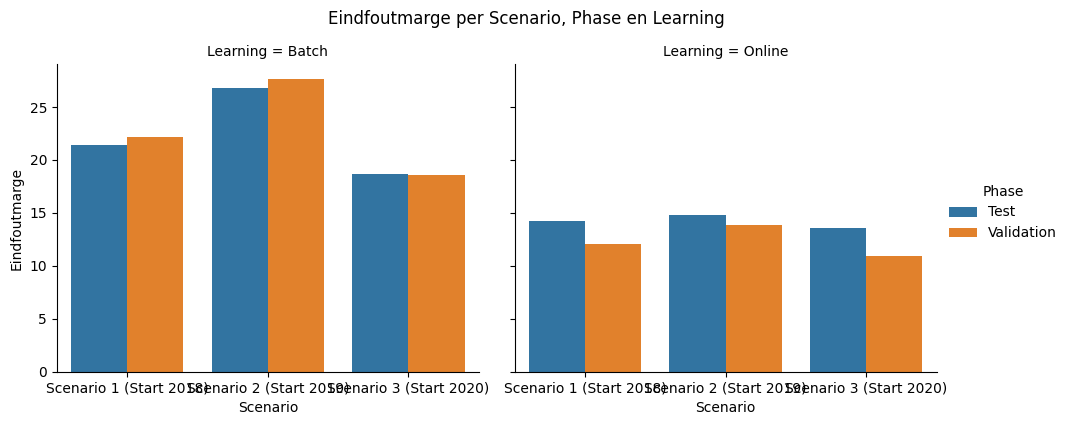

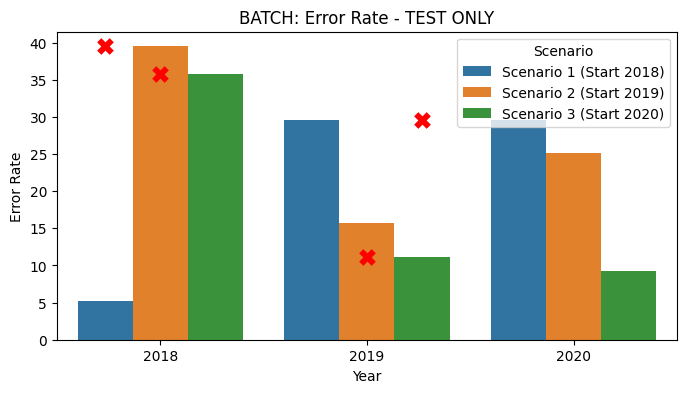

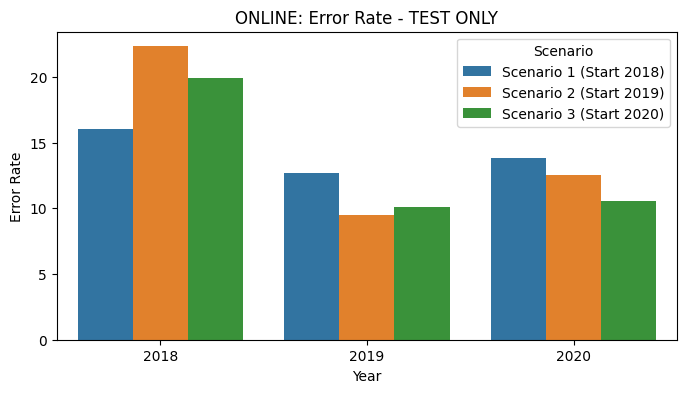

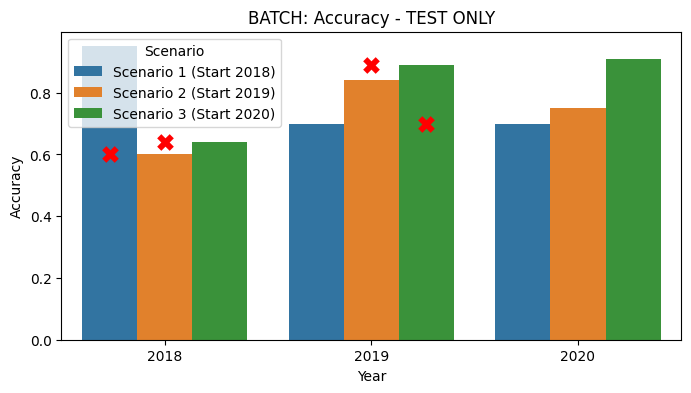

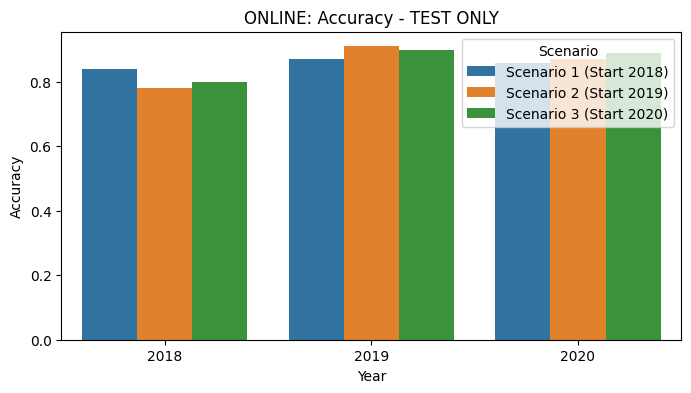

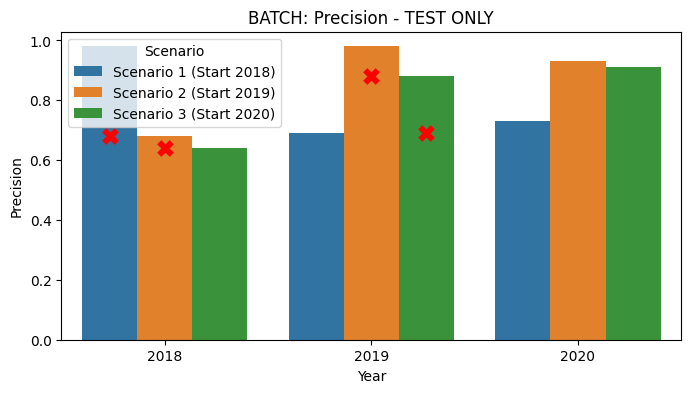

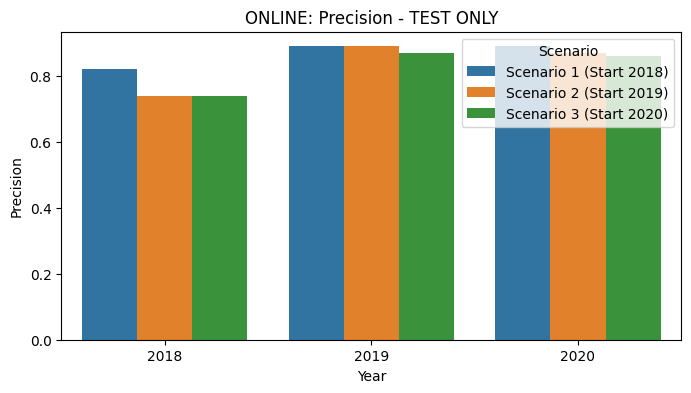

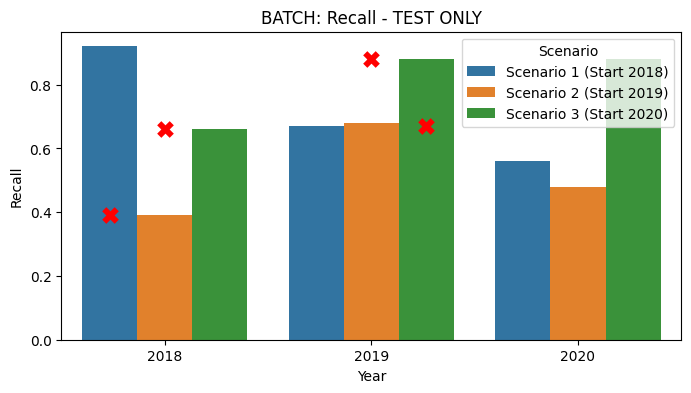

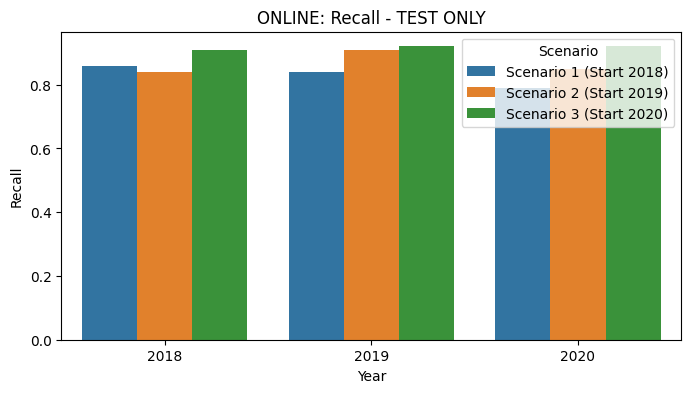

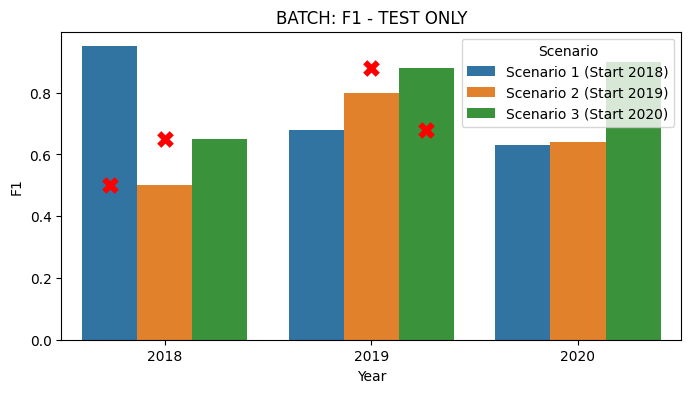

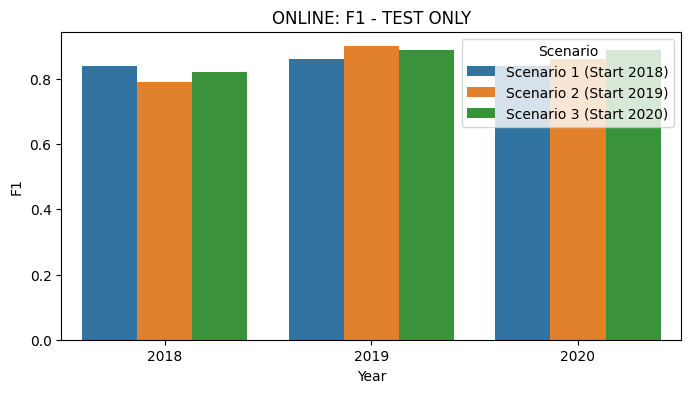

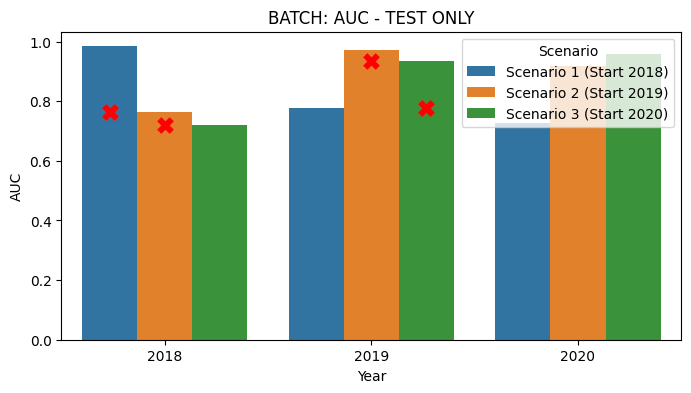

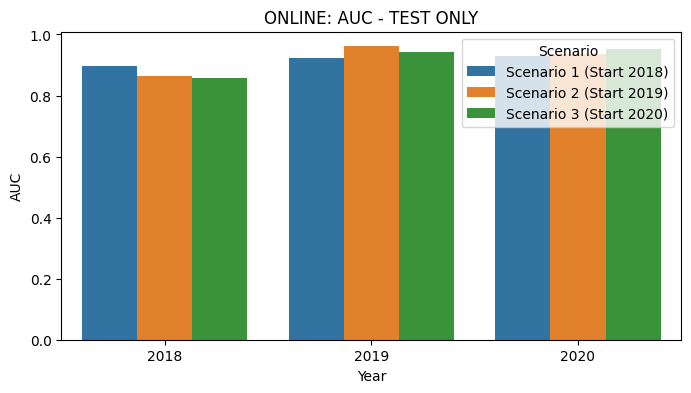


=== df_combined ===
                    Scenario         Model       Phase  Year  Accuracy  \
0   Scenario 1 (Start 2018)   SGD (Batch)  Validation  2018      0.94   
1   Scenario 1 (Start 2018)   SGD (Batch)  Validation  2019      0.69   
2   Scenario 1 (Start 2018)   SGD (Batch)  Validation  2020      0.71   
3   Scenario 1 (Start 2018)   SGD (Batch)        Test  2018      0.95   
4   Scenario 1 (Start 2018)   SGD (Batch)        Test  2019      0.70   
5   Scenario 1 (Start 2018)   SGD (Batch)        Test  2020      0.70   
6   Scenario 2 (Start 2019)   SGD (Batch)  Validation  2019      0.84   
7   Scenario 2 (Start 2019)   SGD (Batch)  Validation  2018      0.58   
8   Scenario 2 (Start 2019)   SGD (Batch)  Validation  2020      0.75   
9   Scenario 2 (Start 2019)   SGD (Batch)        Test  2019      0.84   
10  Scenario 2 (Start 2019)   SGD (Batch)        Test  2018      0.60   
11  Scenario 2 (Start 2019)   SGD (Batch)        Test  2020      0.75   
12  Scenario 3 (Start 2020)  

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, roc_auc_score)

##############################################################################
# 1) ADWIN
##############################################################################
class ADWIN:
    def __init__(self, delta=0.90):
        self.delta = delta
        self.data_window = []
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

    def _calculate_hoeffding_bound(self, n):
        return np.sqrt((1/(2*n)) * np.log(1/self.delta))

    def update(self, value):
        self.data_window.append(value)
        self.width += 1
        self.mean = np.mean(self.data_window)
        self.drift_detected = False
        while len(self.data_window) > 1:
            half = len(self.data_window)//2
            if abs(np.mean(self.data_window[:half]) - np.mean(self.data_window[half:])) > self._calculate_hoeffding_bound(self.width):
                self.data_window.pop(0)
                self.width -= 1
                self.mean = np.mean(self.data_window)
                self.drift_detected = True
            else:
                break
        return self.mean, self.width

    def detected_change(self):
        return self.drift_detected

    def reset(self):
        self.data_window.clear()
        self.mean, self.width = 0.0, 0
        self.drift_detected = False

##############################################################################
# 2) Evaluatie: Accuracy, Error, Precision, Recall, F1, AUC
##############################################################################
def evaluate_batch(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    err = (1 - acc)*100
    prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary', pos_label=1)
    try:
        auc = roc_auc_score(y, model.predict_proba(X)[:,1])
    except AttributeError:
        auc = np.nan
    return dict(Accuracy=acc, Error=err, Precision=prec, Recall=rec, F1=f1, AUC=auc)

##############################################################################
# 3) Data & Scenario's (voorbeelden, pas aan naar eigen data)
##############################################################################
data_dict = {
    2018: {'X_train': X_train_2018, 'y_train': y_train_2018,
           'X_val': X_val_2018,     'y_val': y_val_2018,
           'X_test': X_test_2018,  'y_test': y_test_2018},
    2019: {'X_train': X_train_2019, 'y_train': y_train_2019,
           'X_val': X_val_2019,     'y_val': y_val_2019,
           'X_test': X_test_2019,  'y_test': y_test_2019},
    2020: {'X_train': X_train_2020, 'y_train': y_train_2020,
           'X_val': X_val_2020,     'y_val': y_val_2020,
           'X_test': X_test_2020,  'y_test': y_test_2020}
}
scenarios = [
    dict(scenario_name="Scenario 1 (Start 2018)", start_year=2018, val_order=[2018, 2019, 2020], test_order=[2018, 2019, 2020]),
    dict(scenario_name="Scenario 2 (Start 2019)", start_year=2019, val_order=[2019, 2018, 2020], test_order=[2019, 2018, 2020]),
    dict(scenario_name="Scenario 3 (Start 2020)", start_year=2020, val_order=[2020, 2018, 2019], test_order=[2020, 2018, 2019])
]

##############################################################################
# 4) Models
##############################################################################
batch_model_configs = {"SGD (Batch)": SGDClassifier(loss= 'log_loss', penalty= 'l1', alpha= 0.000001, learning_rate= 'constant', eta0= 1.0, warm_start=False, random_state=42)}
#online_model_configs= {"SGD (Online)":SGDClassifier(loss="log_loss", warm_start=True, random_state=42)}
online_model_configs = {"SGD (Online)": SGDClassifier(loss= 'log_loss', penalty= 'l1', alpha= 0.000001, learning_rate= 'constant', eta0= 1.0, warm_start=False, random_state=42)}
##############################################################################
# 5) Universele scenario-run
##############################################################################
def detect_drift(adwin, error_rate):
    before = adwin.mean
    adwin.update(error_rate/100.0)
    return "Drift" if abs(before - adwin.mean) > adwin._calculate_hoeffding_bound(adwin.width) else "Stable"

def result_row(scenario, model_name, phase, year, metrics, drift):
    return {
        "Scenario": scenario['scenario_name'],
        "Model": model_name,
        "Phase": phase,
        "Year": year,
        "Accuracy": round(metrics["Accuracy"],2),
        "Error Rate": round(metrics["Error"],2),
        "Precision": round(metrics["Precision"],2),
        "Recall": round(metrics["Recall"],2),
        "F1": round(metrics["F1"],2),
        "AUC": round(metrics["AUC"],3) if not np.isnan(metrics["AUC"]) else np.nan,
        "Drift Status": drift
    }

def run_scenario(scenario, model_dict, mode="batch", adwin_delta=0.90):
    results=[]
    for model_name, model in model_dict.items():
        if mode=="online" and not hasattr(model,"partial_fit"):
            continue
        start = scenario['start_year']
        # Init
        model.fit(data_dict[start]['X_train'], data_dict[start]['y_train'])
        adwin=ADWIN(adwin_delta)

        # Validatie
        for year in scenario['val_order']:
            if mode=="online" and year!=start:
                model.partial_fit(data_dict[year]['X_train'], data_dict[year]['y_train'])
            mets= evaluate_batch(model, data_dict[year]['X_val'], data_dict[year]['y_val'])
            drift= "N/A" if year==start else detect_drift(adwin,mets["Error"])
            results.append(result_row(scenario, model_name, "Validation", year, mets, drift))
        # Test
        adwin.reset()
        for year in scenario['test_order']:
            mets= evaluate_batch(model, data_dict[year]['X_test'], data_dict[year]['y_test'])
            drift= "N/A" if year==start else detect_drift(adwin,mets["Error"])
            results.append(result_row(scenario, model_name, "Test", year, mets, drift))
    return results

##############################################################################
# 6) Run batch + online
##############################################################################
all_batch=[]
all_online=[]
for sc in scenarios:
    all_batch += run_scenario(sc, batch_model_configs, mode="batch", adwin_delta=0.90)
    all_online+= run_scenario(sc, online_model_configs,mode="online",adwin_delta=0.90)

df_batch = pd.DataFrame(all_batch);  df_batch["Learning"]="Batch"
df_online= pd.DataFrame(all_online); df_online["Learning"]="Online"
df_combined= pd.concat([df_batch, df_online], ignore_index=True)

##############################################################################
# 7) Eindfoutmarge-plot
##############################################################################
endfoutmarge_df = (df_combined
    .groupby(["Scenario","Phase","Learning"],as_index=False)["Error Rate"]
    .mean().rename(columns={"Error Rate":"Eindfoutmarge"})
)

plt.figure(figsize=(10,4))
g = sns.catplot(
    data=endfoutmarge_df,
    x="Scenario", y="Eindfoutmarge",
    hue="Phase", col="Learning",
    kind="bar", height=4, aspect=1.2
)
g.fig.suptitle("Eindfoutmarge per Scenario, Phase en Learning", y=1.05)
plt.show()

##############################################################################
# 8) Hulpfunctie: Metric-barplot + driftmarkers
##############################################################################
def plot_metric_barplusdrift(df, metric, title_prefix):
    plt.figure(figsize=(8,4))
    ax = sns.barplot(data=df, x="Year", y=metric, hue="Scenario", dodge=True)
    plt.title(f"{title_prefix}: {metric} - TEST ONLY")
    drift_df = df[df["Drift Status"]=="Drift"]
    if not drift_df.empty:
        sns.stripplot(
            data=drift_df, x="Year", y=metric, hue="Scenario",
            marker="X", size=12, palette=["red"]*3,
            dodge=True, edgecolor="black", ax=ax, legend=False
        )
    ax.legend(title="Scenario")
    plt.show()

##############################################################################
# 9) Voorbeeldplots (Batch + Online, Testfase)
##############################################################################
df_batch_test  = df_batch [df_batch["Phase"]=="Test"].copy()
df_online_test = df_online[df_online["Phase"]=="Test"].copy()

for m in ["Error Rate", "Accuracy", "Precision", "Recall", "F1", "AUC"]:
    plot_metric_barplusdrift(df_batch_test,  m, "BATCH")
    plot_metric_barplusdrift(df_online_test, m, "ONLINE")

print("\n=== df_combined ===\n", df_combined)
print("\n=== Eindfoutmarge ===\n", endfoutmarge_df)


##############################################################################
# 10) Gecombineerde Tabel (Scenario, Year, Accuracy, Error, Precision, Recall, F1, Drifts) - BATCH
##############################################################################
# Filter op Batch + Testfase
df_batch_test2 = df_batch_test.copy()  # maak een kopie zodat we niets overschrijven
df_batch_test2["DriftBinary"] = (df_batch_test2["Drift Status"] == "Drift").astype(int)

df_batch_summary = (
    df_batch_test2
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"   # tel het aantal drift-incidenten
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)

print("\n=== Gecombineerde Tabel (Batch, Testfase): Accuracy, Error, Precision, Recall, F1, Drifts ===")
print(df_batch_summary)


##############################################################################
# 10b) Gecombineerde Tabel (Scenario, Year, Accuracy, Error, Precision, Recall, F1, Drifts) - ONLINE
##############################################################################
# Filter op Online + Testfase
df_online_test2 = df_online_test.copy()
df_online_test2["DriftBinary"] = (df_online_test2["Drift Status"] == "Drift").astype(int)

df_online_summary = (
    df_online_test2
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)

print("\n=== Gecombineerde Tabel (Online, Testfase): Accuracy, Error, Precision, Recall, F1, Drifts ===")
print(df_online_summary)


#Eindevaluatie

##Random Forest (Batch) vs SGD(Batch) gefinetuned vs SGD(online) gefinetuned

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import joblib  # For saving/loading models

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier

##############################################################################
# 1) ADWIN
##############################################################################
class ADWIN:
    def __init__(self, delta=0.90):
        self.delta = delta
        self.data_window = []
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

    def _calculate_hoeffding_bound(self, n):
        return np.sqrt((1/(2*n)) * np.log(1/self.delta))

    def update(self, value):
        self.data_window.append(value)
        self.width += 1
        self.mean = np.mean(self.data_window)
        self.drift_detected = False

        while len(self.data_window) > 1:
            half = len(self.data_window)//2
            left_mean = np.mean(self.data_window[:half])
            right_mean= np.mean(self.data_window[half:])
            if abs(left_mean - right_mean) > self._calculate_hoeffding_bound(self.width):
                self.data_window.pop(0)
                self.width -= 1
                self.mean = np.mean(self.data_window)
                self.drift_detected = True
            else:
                break
        return self.mean, self.width

    def detected_change(self):
        return self.drift_detected

    def reset(self):
        self.data_window.clear()
        self.mean = 0.0
        self.width = 0
        self.drift_detected = False

##############################################################################
# 2) Evaluatie (zonder AUC): Accuracy, Error, Precision, Recall, F1
##############################################################################
def evaluate_batch(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    err = (1 - acc)*100
    prec, rec, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='binary', pos_label=1
    )
    return dict(
        Accuracy=acc,
        Error=err,
        Precision=prec,
        Recall=rec,
        F1=f1
    )

##############################################################################
# 3) Data & Scenario's
#    (Pas aan aan je eigen X_train, X_val, X_test per jaar)
##############################################################################
# Bijv.:
# data_dict = {
#     2018: {'X_train': X_train_2018, 'y_train': y_train_2018,
#            'X_val':   X_val_2018,   'y_val':   y_val_2018,
#            'X_test':  X_test_2018,  'y_test':  y_test_2018},
#     ...
# }
data_dict = {
    2018: {'X_train': X_train_2018, 'y_train': y_train_2018,
           'X_val':   X_val_2018,   'y_val':   y_val_2018,
           'X_test':  X_test_2018,  'y_test':  y_test_2018},
    2019: {'X_train': X_train_2019, 'y_train': y_train_2019,
           'X_val':   X_val_2019,   'y_val':   y_val_2019,
           'X_test':  X_test_2019,  'y_test':  y_test_2019},
    2020: {'X_train': X_train_2020, 'y_train': y_train_2020,
           'X_val':   X_val_2020,   'y_val':   y_val_2020,
           'X_test':  X_test_2020,  'y_test':  y_test_2020}
}

scenarios = [
    dict(
        scenario_name="Scenario 1 (Start 2018)",
        start_year=2018,
        val_order=[2018, 2019, 2020],
        test_order=[2018, 2019, 2020]
    ),
    dict(
        scenario_name="Scenario 2 (Start 2019)",
        start_year=2019,
        val_order=[2019, 2018, 2020],
        test_order=[2019, 2018, 2020]
    ),
    dict(
        scenario_name="Scenario 3 (Start 2020)",
        start_year=2020,
        val_order=[2020, 2018, 2019],
        test_order=[2020, 2018, 2019]
    )
]

##############################################################################
# 4) Models
##############################################################################
batch_model_configs = {
    "SGD (Batch)": SGDClassifier(
        loss='log_loss',
        penalty='l1',
        alpha=1e-6,
        learning_rate='constant',
        eta0=1.0,
        warm_start=False,
        random_state=42
    ),
    "RandomForest (Batch)": RandomForestClassifier(
        random_state=42
    )
}

online_model_configs = {
    "SGD (Online)": SGDClassifier(
        loss='log_loss',
        penalty='l1',
        alpha=1e-6,
        learning_rate='constant',
        eta0=1.0,
        warm_start=False,
        random_state=42
    )
}

##############################################################################
# 5) Universele scenario-run (returns results + final trained models)
##############################################################################
def detect_drift(adwin, error_rate):
    before = adwin.mean
    adwin.update(error_rate / 100.0)
    bound = adwin._calculate_hoeffding_bound(adwin.width)
    return "Drift" if abs(before - adwin.mean) > bound else "Stable"

def result_row(scenario, model_name, phase, year, metrics, drift):
    return {
        "Scenario": scenario['scenario_name'],
        "Model": model_name,
        "Phase": phase,
        "Year": year,
        "Accuracy": round(metrics["Accuracy"],2),
        "Error Rate": round(metrics["Error"],2),
        "Precision": round(metrics["Precision"],2),
        "Recall": round(metrics["Recall"],2),
        "F1": round(metrics["F1"],2),
        "Drift Status": drift
    }

def run_scenario(scenario, model_dict, mode="batch", adwin_delta=0.90):
    """
    Returns:
      (1) results (list of dicts)
      (2) final_models (dict of final trained models keyed by model_name)
    """
    results = []
    final_models = {}

    start = scenario['start_year']

    for model_name, model in model_dict.items():
        # Sla over als model niet geschikt is voor partial_fit
        if mode == "online" and not hasattr(model, "partial_fit"):
            continue

        # Initieel trainen
        model.fit(data_dict[start]['X_train'], data_dict[start]['y_train'])

        # ADWIN
        adwin = ADWIN(adwin_delta)

        # VALIDATIE
        for year in scenario['val_order']:
            if mode == "online" and (year != start):
                model.partial_fit(
                    data_dict[year]['X_train'],
                    data_dict[year]['y_train']
                )
            mets = evaluate_batch(model, data_dict[year]['X_val'], data_dict[year]['y_val'])
            drift = "N/A" if year == start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Validation", year, mets, drift))

        # TEST
        adwin.reset()
        for year in scenario['test_order']:
            mets = evaluate_batch(model, data_dict[year]['X_test'], data_dict[year]['y_test'])
            drift = "N/A" if year == start else detect_drift(adwin, mets["Error"])
            results.append(result_row(scenario, model_name, "Test", year, mets, drift))

        # Bewaar final model
        final_models[model_name] = model

    return results, final_models

##############################################################################
# 6) Scenario-runs + Opslaan van SGD (Online) model voor ALLE scenario's
##############################################################################
all_batch = []
all_online = []

# Dictionary om de bestandsnamen te mappen aan scenario's
scenario_file_map = {
    "Scenario 1 (Start 2018)": "sgd_online_scenario1.pkl",
    "Scenario 2 (Start 2019)": "sgd_online_scenario2.pkl",
    "Scenario 3 (Start 2020)": "sgd_online_scenario3.pkl"
}

for sc in scenarios:
    # BATCH
    batch_results, batch_models = run_scenario(
        sc, batch_model_configs, mode="batch", adwin_delta=0.90
    )
    all_batch += batch_results

    # ONLINE
    online_results, online_models = run_scenario(
        sc, online_model_configs, mode="online", adwin_delta=0.90
    )
    all_online += online_results

    # Check of er een "SGD (Online)" model is en bewaar met bestandsnaam op basis van scenario
    if "SGD (Online)" in online_models:
        scenario_name = sc["scenario_name"]
        file_name = scenario_file_map.get(scenario_name, "sgd_online_default.pkl")

        # **Pas hier het volledige pad aan** voor je Google Drive
        save_path = f'/content/drive/MyDrive/Afstuderen/Deadline/models/{file_name}'

        joblib.dump(online_models["SGD (Online)"], save_path)
        print(f"SGD (Online) model for '{scenario_name}' saved to: {save_path}")

# Combine results in DataFrames
df_batch  = pd.DataFrame(all_batch)
df_batch["Learning"] = "Batch"

df_online = pd.DataFrame(all_online)
df_online["Learning"] = "Online"

df_combined = pd.concat([df_batch, df_online], ignore_index=True)

##############################################################################
# 7) Gemiddelde Eindfoutmarge
##############################################################################
endfoutmarge_df = (
    df_combined
    .groupby(["Scenario","Phase","Learning"], as_index=False)["Error Rate"]
    .mean()
    .rename(columns={"Error Rate": "Eindfoutmarge"})
)

print("\n=== df_combined ===\n", df_combined)
print("\n=== Eindfoutmarge ===\n", endfoutmarge_df)

##############################################################################
# 8) APARTE TABELLEN: BATCH TESTFASE
##############################################################################
df_batch_test = df_batch[df_batch["Phase"]=="Test"].copy()
df_batch_test["DriftBinary"] = (df_batch_test["Drift Status"] == "Drift").astype(int)

# --- (A) SGD (Batch) ---
df_batch_test_sgd = df_batch_test[df_batch_test["Model"] == "SGD (Batch)"]
df_batch_sgd_summary = (
    df_batch_test_sgd
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)
print("\n=== (Batch, Testfase) - SGD ===")
print(df_batch_sgd_summary)

# --- (B) RandomForest (Batch) ---
df_batch_test_rf = df_batch_test[df_batch_test["Model"] == "RandomForest (Batch)"]
df_batch_rf_summary = (
    df_batch_test_rf
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)
print("\n=== (Batch, Testfase) - RandomForest ===")
print(df_batch_rf_summary)

##############################################################################
# 9) TABEL (ONLINE, TESTFASE)
##############################################################################
df_online_test = df_online[df_online["Phase"]=="Test"].copy()
df_online_test["DriftBinary"] = (df_online_test["Drift Status"] == "Drift").astype(int)

df_online_summary = (
    df_online_test
    .groupby(["Scenario","Year"], as_index=False)
    .agg({
        "Accuracy": "mean",
        "Error Rate": "mean",
        "Precision": "mean",
        "Recall": "mean",
        "F1": "mean",
        "DriftBinary": "sum"
    })
    .rename(columns={"DriftBinary": "Drifts"})
    .round(2)
)
print("\n=== (Online, Testfase) ===")
print(df_online_summary)


SGD (Online) model for 'Scenario 1 (Start 2018)' saved to: /content/drive/MyDrive/Afstuderen/Deadline/models/sgd_online_scenario1.pkl
SGD (Online) model for 'Scenario 2 (Start 2019)' saved to: /content/drive/MyDrive/Afstuderen/Deadline/models/sgd_online_scenario2.pkl
SGD (Online) model for 'Scenario 3 (Start 2020)' saved to: /content/drive/MyDrive/Afstuderen/Deadline/models/sgd_online_scenario3.pkl

=== df_combined ===
                    Scenario                 Model       Phase  Year  Accuracy  \
0   Scenario 1 (Start 2018)           SGD (Batch)  Validation  2018      0.94   
1   Scenario 1 (Start 2018)           SGD (Batch)  Validation  2019      0.69   
2   Scenario 1 (Start 2018)           SGD (Batch)  Validation  2020      0.71   
3   Scenario 1 (Start 2018)           SGD (Batch)        Test  2018      0.95   
4   Scenario 1 (Start 2018)           SGD (Batch)        Test  2019      0.70   
5   Scenario 1 (Start 2018)           SGD (Batch)        Test  2020      0.70   
6   Scena

###Model opgeslagen

In [ ]:
import joblib
sgd_online_model = joblib.load("/content/drive/MyDrive/Afstuderen/Deadline/models/sgd_online_scenario1.pkl")
print(sgd_online_model)

SGDClassifier(alpha=1e-06, eta0=1.0, learning_rate='constant', loss='log_loss',
              penalty='l1', random_state=42)


###Overzicht - Accuracy

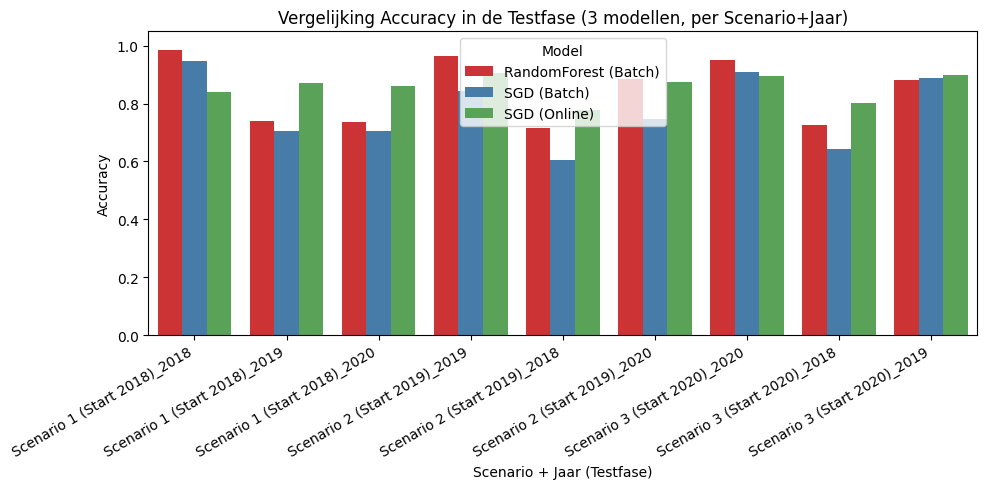

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Stel: df_combined bevat alle resultaten
# en heeft o.a. kolommen: "Phase", "Model", "Scenario", "Year", "Accuracy", ...
# Voorbeeld van model-namen: ["RandomForest (Batch)", "SGD (Batch)", "SGD (Online)"]

# 1) Filter enkel de testfase en de drie modellen die je wilt vergelijken
df_test = df_combined[
    (df_combined["Phase"] == "Test") &
    (df_combined["Model"].isin(["RandomForest (Batch)", "SGD (Batch)", "SGD (Online)"]))
].copy()

# 2) Voor de X-as willen we per scenario+jaar een 'categorie'
#    Bijvoorbeeld: "Scenario 1 (Start 2018)_2018"
df_test["Scenario_Year"] = df_test["Scenario"] + "_" + df_test["Year"].astype(str)

# 3) Maak de plot met Seaborn barplot
plt.figure(figsize=(10, 5))  # pas aan naar wens
sns.barplot(
    data=df_test,
    x="Scenario_Year", y="Accuracy",
    hue="Model",
    palette="Set1"
)

# 4) Optionele styling
plt.title("Vergelijking Accuracy in de Testfase (3 modellen, per Scenario+Jaar)")
plt.xticks(rotation=30, ha="right")  # labels iets gedraaid voor leesbaarheid
plt.ylim(0, 1.05)                    # accuracy ligt tussen 0 en 1
plt.ylabel("Accuracy")
plt.xlabel("Scenario + Jaar (Testfase)")

plt.legend(title="Model")
plt.tight_layout()
plt.show()


###Overzicht - Error Rate

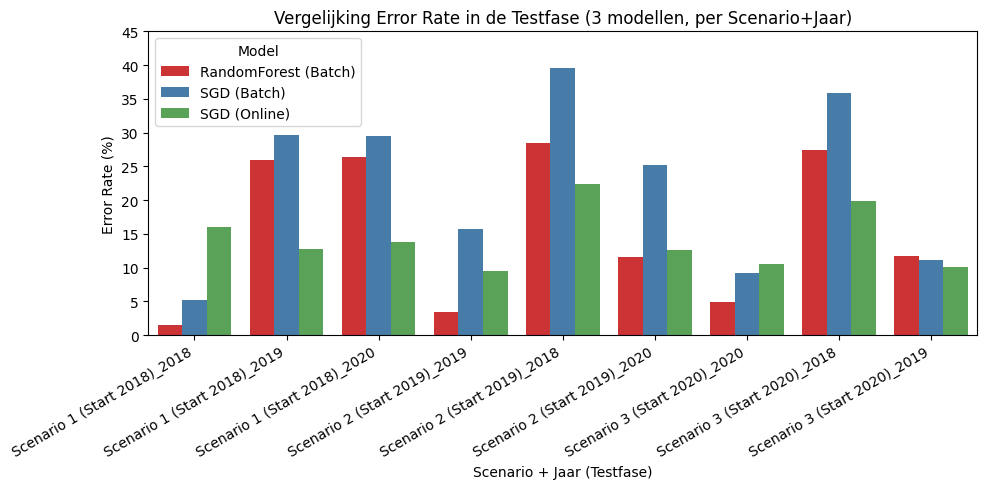

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Stel: df_combined bevat alle resultaten
# en heeft o.a. kolommen: "Phase", "Model", "Scenario", "Year", "Error Rate", ...
# Voorbeeld van model-namen: ["RandomForest (Batch)", "SGD (Batch)", "SGD (Online)"]

# 1) Filter enkel de testfase en de drie modellen die je wilt vergelijken
df_test = df_combined[
    (df_combined["Phase"] == "Test") &
    (df_combined["Model"].isin(["RandomForest (Batch)", "SGD (Batch)", "SGD (Online)"]))
].copy()

# 2) Voor de X-as willen we per scenario+jaar een 'categorie'
df_test["Scenario_Year"] = df_test["Scenario"] + "_" + df_test["Year"].astype(str)

# 3) Plot met Seaborn barplot
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_test,
    x="Scenario_Year", y="Error Rate",
    hue="Model",
    palette="Set1"
)

# 4) Styling
plt.title("Vergelijking Error Rate in de Testfase (3 modellen, per Scenario+Jaar)")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Error Rate (%)")
plt.xlabel("Scenario + Jaar (Testfase)")
plt.ylim(0, 45)  # Als Error Rate in procenten is
plt.legend(title="Model")
plt.tight_layout()
plt.show()
